# All

## Import/read

In [155]:
import os
import pickle
import time
import warnings
from copy import deepcopy
from datetime import datetime
from itertools import repeat
from types import SimpleNamespace
from typing import Callable

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import (
    BayesianOptimization,
    SequentialDomainReductionTransformer,
    UtilityFunction,
)
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import (
    Any,
    Bool,
    Callable,
    Dict,
    Float,
    HasTraits,
    Int,
    List,
    TraitError,
    TraitType,
    Tuple,
    Unicode,
    default,
    validate,
)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [156]:
data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"
bayesian_run_path = "../data/bayesian_runs/"


def read_file(filename, sub_folder="kaggle", delimiter=","):
    df = pd.read_csv(os.path.join(data_path, sub_folder, filename), delimiter=delimiter)

    if filename == "train.csv":
        df_revealed_test = read_file("revealed_test.csv")
        return (
            pd.concat([df, df_revealed_test], axis=0)
            .sort_values(["cfips", "first_day_of_month"])
            .reset_index(drop=True)
        )
    return df

In [157]:
df_census = read_file("census_starter.csv")
df_test = read_file("test.csv")
df_train = read_file("train.csv")
df_submission = read_file("sample_submission.csv")
df_population = read_file('df_population.csv', 'other')

df_boundaries = read_file("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")

### Add census, year, fix dates etc

In [158]:
def fix_df_train(df_train):
    df = df_train.copy()

    # Add year
    df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
    df["year"] = df["first_day_of_month"].dt.year.astype(int)

    # Add df_census to df
    cols = list(df_census.columns)
    cols.remove("cfips")

    t0 = df_census.melt("cfips", cols)
    t0["year"] = t0["variable"].str.split("_").str[-1].astype(int)
    t0["variable_name"] = t0["variable"].str.rsplit("_", expand=False, n=1).str[0]

    t1 = pd.pivot_table(t0, "value", ["cfips", "year"], "variable_name").reset_index()

    # Census data is lagging 2 years
    t1["year"] = t1["year"] + 2

    df = pd.merge(df, t1, "left", left_on=["cfips", "year"], right_on=["cfips", "year"])

    # Add month
    df["month"] = df["first_day_of_month"].dt.month

    return df

In [159]:
df_train = fix_df_train(df_train)

t = df_train[df_train.isna().any(axis=1)]
if t.shape[0] != 24:
    raise Exception("Nan counts used to be 24... something changed")

In [160]:
df_train[df_train.isna().any(axis=1)].shape

(24, 14)

### Weather save/load

In [161]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:
            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [162]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [163]:
df_weather = pd.read_csv(path_weather)

### Baseline model

#### Feature functions

In [164]:
def _loop_new_cols(
    df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f: callable,target_col:str, groupby_col: str
) -> pd.DataFrame:
    res = []
    for idx, row in df_mapped_feature.iterrows():
        r = f(df, idx, target_col, groupby_col, int(row["params"]))
        res.append(r)

    return pd.concat(res, axis=1)

def f_rolling_mean(
    df: pd.DataFrame,
    df_mapped_feature: pd.DataFrame,
    target_col: str,
    f_col: str,
    groupby_col: str,
    **kwargs
):
    def _f(df: pd.DataFrame, col: str, target_col: str, groupby_col: str, window: int):
        assert window > 0, "Window has to be above 0"
        rolling_mean = (
            df.sort_values([groupby_col, "first_day_of_month"])
            .groupby([groupby_col])[target_col]
            .rolling(window, closed="left")
            .mean()
            .rename(col)
            .reset_index(drop=True)
        )
        rolling_mean.index = df["row_id"]

        return rolling_mean

    return _loop_new_cols(df, df_mapped_feature, _f, target_col, groupby_col)

def f_shifted(df: pd.DataFrame, col: str, shift: int) -> pd.DataFrame:
    assert shift >= 1, "lower shift leads to leakage of target variable"
    shifted = (
        df.sort_values(["cfips", "first_day_of_month"])
        .groupby(["cfips"])[target_col]
        .shift(shift)
        .rename(col)
        .reset_index(drop=True)
    )
    shifted.index = df["row_id"]

    return shifted

In [165]:
def add_feature_targets_history(
    df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f_col: str, **kwargs
) -> (str, pd.DataFrame):
    """
    Add rolling windows and/or shifted values

    window: list
        List of windows to add. [2, 5] will add two columns with rolling window 2 and 5.
    shifts: list
        List of recents shifts to add. [2, 5] will add two columns with shifts of 2 and 5.
    """

    def add_rolling_mean_x(df: pd.DataFrame, col: str, window: int) -> pd.DataFrame:
        assert window > 0, "Window has to be above 0"
        rolling_mean = (
            df.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])[target_col]
            .rolling(window, closed="left")
            .mean()
            .rename(col)
            .reset_index(drop=True)
        )
        rolling_mean.index = df["row_id"]

        return rolling_mean

    def add_shifted_x(df: pd.DataFrame, col: str, shift: int) -> pd.DataFrame:
        assert shift >= 1, "lower shift leads to leakage of target variable"
        shifted = (
            df.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])[target_col]
            .shift(shift)
            .rename(col)
            .reset_index(drop=True)
        )
        shifted.index = df["row_id"]

        return shifted

    def _loop_new_cols(
        df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f: callable
    ) -> pd.DataFrame:
        res = []
        for idx, row in df_mapped_feature.iterrows():
            r = f(df, idx, int(row["params"]))
            res.append(r)

        return pd.concat(res, axis=1)

    # global _df
    # _df = df_mapped_feature

    if f_col == "target_rolling_mean":
        return _loop_new_cols(df, df_mapped_feature, add_rolling_mean_x)
    elif f_col == "target_shift":
        return _loop_new_cols(df, df_mapped_feature, add_shifted_x)
    else:
        raise ValueError("f_col ´{f_col}´ is not supported")

In [166]:
def add_categorical_feature(df: pd.DataFrame, f_col: str, **kwargs):
    return df[['row_id', f_col]].set_index('row_id').astype('category')

def add_numerical_feature(df: pd.DataFrame, f_col: str, **kwargs):
    return df[['row_id', f_col]].set_index('row_id')

def time_arrow(df: pd.DataFrame, f_col: str, **kwargs):
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    seconds_since = df["first_day_of_month"].astype("int64") // 1e9
    df[f_col] = NormalizeData(seconds_since)

    return df[['row_id', f_col]].set_index('row_id')

In [167]:
def add_feature_targets_groupby_stats(
    df,
    f_col,
    # new_col_template="{}_target_{}",
    agg_function=None,
    # agg_functions=["mean", "std", "median"],
    train_idx=None,
    col=None,
    **kwargs
):
    df = df.copy()
    t0 = df.groupby(col)["microbusiness_density"].agg(agg_function)
    t0 = t0.rename(f_col)

    df = pd.merge(df, t0, "left", left_on=col, right_index=True).set_index('row_id')
    return pd.DataFrame(df[f_col])

In [168]:
def correlated_states(df_train):
    """
    Find states that correlate well in terms of change in ´microbusiness_density´
    """
    cols_state_relation = []
    dfs = pd.DataFrame([])
    new_col_raw = "mean"

    # Rolling
    t0 = (
        df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    t1 = t0.pivot_table(new_col_raw, "first_day_of_month", "state").sort_index().corr()
    # plt.imshow(t1.values, cmap="hot", interpolation="nearest")
    # plt.show()

    t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
    t5 = t5[t5["state"] != t5["other_state"]]

    # Clean pairs of same correlations
    t5 = t5.sort_values("corr").reset_index(drop=True)
    cols = ["state", "other_state"]
    t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
    t5 = t5.drop_duplicates()

    # Cluster
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))
    t5["cluster"] = clustering.labels_

    # Iterate through pairs and add state means to each other
    corr_states = t5[abs(t5["corr"]) > 0.9]

    # Append one month.
    t2 = df_train.copy()
    t2["first_day_of_month"] = t2["first_day_of_month"] + pd.DateOffset(months=1)
    t0 = (
        t2.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    # Iterate over the pairs
    for pair in corr_states.values:
        group = pair[:2]
        corr = pair[2]

        switched = t0[t0["state"].isin(group)].copy()

        state_0 = group[0]
        state_1 = group[1]

        s = "{}_{}_rolling_microbusiness_density"
        col_state_0 = s.format(state_0, state_1)
        col_state_1 = s.format(state_1, state_0)

        sw = pd.pivot_table(
            switched, new_col_raw, "first_day_of_month", "state"
        ).rename(columns={state_0: col_state_0, state_1: col_state_1})

        def boo(df, sw, state, col_state, corr):
            """
            I think it switches state labels.
            """
            corr_col = "corr_" + col_state
            # sw[corr_col] = corr

            df_state_t = sw[[col_state]].reset_index()
            df_state_t["state"] = state

            # df = pd.merge(
            #     df,
            #     df_state_t,
            #     "left",
            # left_on=["state", "first_day_of_month"],
            # right_on=["state", "first_day_of_month"],
            # )

            return (df_state_t, corr_col)

        df_state_t_0, corr_col_0 = boo(df_train, sw, state_1, col_state_0, corr)
        df_state_t_1, corr_col_1 = boo(df_train, sw, state_0, col_state_1, corr)

        # Append results to list
        if dfs.shape[0] == 0:
            dfs = pd.merge(
                df_state_t_0,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        else:
            dfs = pd.merge(
                dfs,
                df_state_t_0,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
            dfs = pd.merge(
                dfs,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        # cols_state_relation.extend([corr_col_0, corr_col_1])
        cols_state_relation.extend([col_state_0, col_state_1])

    return (dfs, cols_state_relation)

In [169]:
def state_cluster(df_train):
    t0 = df_train.groupby("state")["microbusiness_density"].agg(["mean", "std"])
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(t0.values)
    t0["cluster"] = clustering.labels_

    return t0.reset_index()[["state", "cluster"]]

##### Maybe pile

In [170]:
def ups_downs(df_train):
    """
    Counts ups and downs until the latest known time. Returns the percetage of ups/downs
    """
    col = "microbusiness_shift_bool_over_pct"
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    added_feature_cols.append(col)

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

#### Misc functions

In [171]:

# def remove_outliers(train, outlier_multiplier):
#     """
#     Remove outlies. Should be run on train only
#     """
#     max_density = (
#         train.groupby("cfips")["microbusiness_density"]
#         .mean()
#         .rename("max_microbusiness_density")
#         .reset_index()
#     )
#     max_density["max_microbusiness_density"] = (
#         max_density["max_microbusiness_density"] * outlier_multiplier
#     )
#     t1 = pd.merge(
#         train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
#     )

#     idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
#     t = train.loc[idx].copy()

#     return t


def smape(pred, eval_data):
    if hasattr(eval_data, "label"):
        A = eval_data.label  # Used by lightgbm
    else:
        A = eval_data  # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False


def remove_empty_folders(path_abs):
    walk = list(os.walk(path_abs))
    for path, _, _ in walk[::-1]:
        if len(os.listdir(path)) == 0:
            os.rmdir(path)


def save_bayesian_results(loss_fn: str, results: list[dict], best: dict):
    def save_pkl(full_path, data):
        with open(full_path, "wb") as f:
            pickle.dump(data, f)

    # Create folders
    dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    subfolder = "{}_{}".format(dt, abs(round(best["target"], 4)))
    bay_result_dir = os.path.join(bayesian_run_path, loss_fn, subfolder)

    if not os.path.exists(bay_result_dir):
        os.makedirs(bay_result_dir)

    # Full paths
    result_path = os.path.join(bay_result_dir, "result.pkl")
    best_path = os.path.join(bay_result_dir, "best.pkl")

    # Save pickles
    save_pkl(result_path, results)
    save_pkl(best_path, best)

    # Remove empty folders that can trash the place
    remove_empty_folders(bayesian_run_path)


def read_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

## Train

### Column mapping

#### Progress

In [172]:
def cell_vars(offset=0):
    
    def filter_feature_class_only(result):
        feature_class_only = {}
        for key, val in result.items():
            if str(type(val)) == "<class '__main__.Feature'>":
                feature_class_only.update({key:val})
                
        return feature_class_only
    
    import io
    from contextlib import redirect_stdout

    ipy = get_ipython()
    out = io.StringIO()

    with redirect_stdout(out):
        ipy.magic("history {0}".format(ipy.execution_count - offset))

    #process each line...
    x = out.getvalue().replace(" ", "").split("\n")
    x = [a.split("=")[0] for a in x if "=" in a] #all of the variables in the cell
    g = globals()
    result = {k:g[k] for k in x if k in g}
    
    feature_class_only = filter_feature_class_only(result)
    
    if len(feature_class_only) == 0:
        raise ValueError('None found. Maybe you changed name AGAIN?')
    
    return feature_class_only

In [173]:
class DataFrame(TraitType):
    """A trait for pd.DataFrame."""

    info_text = "pd.DataFrame"

    def validate(self, obj, value):
        if type(value) == pd.DataFrame:
            return value
        self.error(obj, value)


class Feature(HasTraits):
    # During init

    f_col = Unicode()
    f = Callable()

    bound = Tuple(Float(), Float())

    enabled_bounds = List(bound, minlen=1)
    params_bounds = List(bound)

    # After init

    _enabled_dict = Dict(key_trait=Unicode(), value_trait=bound)
    _params_dict = Dict(key_trait=Unicode(), value_trait=bound)

    relations = Dict(key_trait=Unicode(), value_trait=Unicode())

    _df_enabled_params = DataFrame()

    def __init__(self, f_col, f, df, enabled_bounds=None, params_bounds=None, **kwargs):
        self.f_col = f_col
        self.f = f
        self.df = df
        if enabled_bounds:
            self.enabled_bounds = enabled_bounds
        if params_bounds:
            self.params_bounds = params_bounds

        self._add_self_to_global_feature_objects()
        self._make_enable_and_params_dict()
        self._make_df_enable_params()
        
        self._kwargs = kwargs

    def get_relations(self):
        return self._relations

    def get_enabled_dict(self):
        return self._enabled_dict

    def get_params_dict(self):
        return self._params_dict

    def get_df_enable_params(self):
        return self._df_enabled_params

    def _add_self_to_global_feature_objects(self):
        """
        This global list is used to pick up features by ´ManageFeatures´
        """
        global feature_objects
        feature_objects[self.f_col] = self
    
    def _set_relations(self, d):
        self._relations = d

    def _make_df_enable_params(self):
        d = self.get_relations()
        relation_original = d
        relation_flipped = {v: k for k, v in d.items()}

        # Get relations
        df_relation = pd.DataFrame.from_dict(
            {**relation_original, **relation_flipped},
            orient="index",
            columns=["relation"],
        )

        # Bounds
        df_bounds = pd.DataFrame.from_dict(
            {
                **self._enabled_dict,
                **self._params_dict,
            },
            orient="index",
            columns=["min", "max"],
        )

        # Kind column separating enabled/params
        df_bounds.loc[self._enabled_dict.keys(), "kind"] = "enabled"
        df_bounds.loc[self._params_dict.keys(), "kind"] = "params"

        # Join
        df = pd.merge(df_bounds, df_relation, "left", left_index=True, right_index=True)

        # Add f_col
        df["f_col"] = self.f_col

        # Fill relations where there are none 
        # when feature has no params, but bayes wants to switch it on/off
        
        df['relation'] = df['relation'].fillna(df.index.to_series())

        self._df_enabled_params = df

    def _make_enable_and_params_dict(self):
        """
        Create 2 variables:
        1) self._enabled_dict
        2) self._params_dict
        """
        self._enabled_keys = []
        self._params_keys = []
        for kind in ["enabled", "params"]:
            bounds = getattr(self, "{}_bounds".format(kind))

            d = {}
            key_f_col = "{kind}_{f_col}_{idx}"
            for idx, bound in enumerate(bounds):
                if len(bounds) < 2:
                    idx = ""
                key = key_f_col.format(kind=kind, f_col=self.f_col, idx=idx)
                d[key] = bound

                getattr(self, "_{}_keys".format(kind)).append(key)

            setattr(self, "_{}_dict".format(kind), d)
        # Set relations for all
        d = dict(zip(self._enabled_keys, self._params_keys))
        self._set_relations(d)

    @default("enabled_bounds")
    def _default_value(self):
        return [(0, 1)]

    @validate("params_bounds")
    def _valid_params_bounds(self, proposal):
        params_bounds = proposal["value"]

        if params_bounds is not None:
            len_params_bounds = len(params_bounds)
            len_enabled_bounds = len(self.enabled_bounds)
            if len_params_bounds != len_enabled_bounds:
                raise TraitError(
                    "If defined, ´params_bounds´ ({}) should match in length with ´enabled_bounds´ ({})".format(
                        len_params_bounds, len_enabled_bounds
                    )
                )

        return proposal["value"]

    @validate("enabled_dict")
    def _valid_enabled_dict(self, proposal):
        for key, value in proposal["value"].items():
            bound_min = value[0]
            bound_max = value[1]

            if (bound_min < 0 or bound_min > 1) or (bound_max < 0 or bound_max > 1):
                raise TraitError(
                    "For key ´{}´ bound values have to be between 0 and 1 (both included). Values given: ´{}´".format(
                        key, value
                    )
                )

            if bound_min > bound_max:
                raise TraitError(
                    "Bound min cannot be bigger than max. Values given: ´{}´".format(
                        value
                    )
                )

        return proposal["value"]

In [174]:
class ManageFeatures(HasTraits):
    _feature_objects = Dict(key_trait=Unicode())
    _df_enabled_params = DataFrame()
    _enabled_keys = List(Unicode())
    _model_pbounds = Dict(key_trait=Unicode(), value_trait=Tuple(Float(), Float()))

    def __init__(self, feature_objects):
        self._feature_objects = feature_objects
        # self._target_col = target_col

        self._set_enabled_keys()
        self._set_features_df_enabled_params()

    def set_model_pbounds(self, model_pbounds: dict):
        self._model_pbounds = model_pbounds

    def get_model_params(self, bay_params):
        model_params = {k: v for k, v in bay_params.items() if k in self._model_pbounds}

        model_params["num_iterations"] = round(model_params["num_iterations"])
        model_params["num_leaves"] = round(model_params["num_leaves"])

        return model_params

    def get_pbounds(self):
        df = self._get_features_df_enabled_params()
        df["pbounds"] = list(zip(df["min"], df["max"]))

        return {**self._model_pbounds, **df["pbounds"].to_dict()}

    def generate_features(self, bay_params: dict):
        # Remove model_pbounds
        bay_params = {
            k: v for k, v in bay_params.items() if k not in self._model_pbounds
        }

        df_mapped = self.get_params(bay_params)

        res = []
        for feature in self._iter_feature_objects():
            df_mapped_feature = df_mapped[df_mapped["f_col"] == feature.f_col]

            # Some features are used, some not
            if df_mapped_feature.shape[0] != 0:
                r = feature.f(
                    df=feature.df.copy(),
                    df_mapped_feature=df_mapped_feature,
                    f_col=feature.f_col,
                    **feature._kwargs
                )

                assert (
                    r.index.name == "row_id"
                ), "All features need to have ´row_id´ as index"

                res.append(r)
        df_features = pd.concat(res, axis=1)

        return df_features

    def generate_target(self, df_train: pd.DataFrame, shift=0):
        t0 = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby("cfips")["microbusiness_density"]
            .shift(shift)
        )

        t0.index = df_train["row_id"]

        return t0

    def get_params(self, bay_params: dict):
        # Mapping for columns
        df_mapped = self.get_mapping(bay_params)

        # Params
        idx_params = df_mapped[
            (df_mapped["kind"] == "enabled") & (df_mapped["params"] > 0.5)
        ]["relation"]
        df_params = df_mapped[df_mapped.index.isin(idx_params)]

        return df_params

    def get_mapping(self, bay_params: dict):
        df_enabled_params = self._get_features_df_enabled_params()
        df_bay_params = pd.DataFrame.from_dict(
            bay_params, orient="index", columns=["params"]
        )

        df = pd.merge(
            df_enabled_params, df_bay_params, "outer", left_index=True, right_index=True
        )

        assert (
            df.shape == df.dropna(subset=["pbounds", "params"]).shape
        ), "There should be no NaN values"

        return df

    def _set_enabled_keys(self):
        l = []
        for key, value in self._feature_objects.items():
            l.extend(value._enabled_keys)

        self._enabled_keys = l

    def _get_features_df_enabled_params(self):
        return self._df_enabled_params

    def _set_features_df_enabled_params(self, f="get_df_enable_params"):
        l = []
        # for key, obj in self._feature_objects.items():
        for feature in self._iter_feature_objects():
            l.append(getattr(feature, f)())

        self._df_enabled_params = self._validate_df_duplicate_index_and_concat(l)

    def _validate_df_duplicate_index_and_concat(self, l):
        rows_in_l = 0
        for t in l:
            rows_in_l += t.shape[0]

        df = pd.concat(l)

        assert (
            rows_in_l == df.shape[0]
        ), "Row count should be same. You probably have a duplicate index between diferent ´Feature objects´"

        return df

    def _iter_feature_objects(self) -> Feature:
        for key, obj in self._feature_objects.items():
            yield obj

In [175]:
class ManageDataSplit:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy().set_index("row_id")

        self._train_idx = None
        self._val_idx = None
        self._test_idx = None

        self._set_split_idx()

    def split_data(self, df_features: pd.DataFrame, df_target: pd.DataFrame, objective: str) -> dict:
        idx_wo_nan = df_features.dropna().index.intersection(df_target.dropna().index)

        # Filter with filterin nan rows
        train_filter = (df_features.index.isin(self._train_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )
        val_filter = (df_features.index.isin(self._val_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )
        test_filter = (df_features.index.isin(self._test_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )

        self.constant = 1
        if objective == 'mape':
            self.constant = 1
        
        return {
            "train": {
                "data": df_features[train_filter],
                "label": df_target[train_filter],
            },
            "val": {
                "data": df_features[val_filter],
                "label": df_target[val_filter],
            },
            "test": {
                "data": df_features[test_filter],
                "label": df_target[test_filter],
            },
        }

    def get_model_input(
        self, manage_features: ManageFeatures, df_train, objective=None, bayes_kwargs: dict=None
    ):
        df_features = manage_features.generate_features(bayes_kwargs)
        df_target = manage_features.generate_target(df_train)

        dict_split_df = self.split_data(df_features, df_target, objective)

        lgb_train = lgb.Dataset(**dict_split_df["train"], free_raw_data=False)
        lgb_eval = lgb.Dataset(
            **dict_split_df["val"], reference=lgb_train, free_raw_data=False
        )
        lgb_test = lgb.Dataset(
            **dict_split_df["test"], reference=lgb_train, free_raw_data=False
        )

        model_params = manage_features.get_model_params(bayes_kwargs)

        return (lgb_train, lgb_eval, lgb_test, model_params)

    def get_train_data(self):
        return self.df.loc[self._train_idx]
    
    def _set_split_idx(
        self,
        train_size: float = 0.9,
        val_size: float = 0.05,
        test_size: float = 0.05,
        date_col: str = "first_day_of_month",
    ):
        dates = np.sort(self.df[date_col].unique())

        dates_idx_train_end = int(dates.shape[0] * train_size)
        dates_idx_val_end = int(dates.shape[0] * (train_size + val_size))

        dates_train = dates[0:dates_idx_train_end]
        dates_val = dates[dates_idx_train_end:dates_idx_val_end]
        dates_test = dates[dates_idx_val_end:]

        self._train_idx = self.df[self.df[date_col].isin(dates_train)].index
        self._val_idx = self.df[self.df[date_col].isin(dates_val)].index
        self._test_idx = self.df[self.df[date_col].isin(dates_test)].index

In [176]:
# recorded_evaluations = {}
def build_callbacks(
    early_stopping: int = 0, log_evaluation: int = 0, record_evaluation: dict = None
):
    callbacks = []

    # Stop earlier if no changes
    if early_stopping:
        callbacks.append(lgb.early_stopping(early_stopping, first_metric_only=True))

    # Log every X-th line
    if log_evaluation:
        callbacks.append(lgb.log_evaluation(log_evaluation))

    if record_evaluation is not None:
        assert (
            type(record_evaluation) == dict
        ), "´record_evaluation´ has to be dictionary"
        callbacks.append(lgb.record_evaluation(record_evaluation))

    return callbacks

In [177]:
from itertools import repeat

manage_data_split = ManageDataSplit(df_train)

feature_objects = {}
enabled_tuple = (0, 0.9)
allways_enabled_tuple = (1, 1)
params_tuple = (0, 10)
    
for cols in [
    {'target_col': "microbusiness_density", 'groupby_col': 'cfips'},
    {'target_col': "microbusiness_density", 'groupby_col': 'county'},
    {'target_col': "microbusiness_density", 'groupby_col': 'state'},
]:
    target_col = cols['target_col']
    groupby_col = cols['groupby_col']
    f_col = "{}_{}_rolling_mean".format(groupby_col, target_col)
    feature_target_rolling_mean = Feature(
        f_col,
        f_rolling_mean,
        df_train,
        target_col=target_col,
        groupby_col=groupby_col,
        enabled_bounds=list(repeat(enabled_tuple, 4)),
        params_bounds=list(repeat((1, 10), 4)),
    )

feature_target_shift_mean = Feature(
    "target_shift",
    add_feature_targets_history,
    df_train,
    enabled_bounds=list(repeat(enabled_tuple, 4)),
    params_bounds=list(repeat((1, 10), 4)),
)

for idx, col in enumerate(
    [
        "county",
        "state",
        "cfips",
    ]
):
    _feature = Feature(
        col, add_categorical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

for idx, col in enumerate(
    [
        "median_hh_inc",
        "pct_bb",
        "pct_college",
        "pct_foreign_born",
        "pct_it_workers",
    ]
):
    _feature = Feature(
        col, add_numerical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

feature_time_arrow = Feature(
    "time_arrow", time_arrow, df_train, enabled_bounds=[enabled_tuple]
)

for col in [
    "cfips",
    "state",
    "county",
    "median_hh_inc",
    "pct_bb",
    "pct_college",
    "pct_foreign_born",
    "pct_it_workers",
]:
    for agg_function in ["median", "mean", "std"]:
        f_col = new_col_template = "{}_target_{}".format(col, agg_function)
        _feature = Feature(
            f_col,
            add_feature_targets_groupby_stats,
            df_train,
            col=col,
            agg_function=agg_function,
            enabled_bounds=[enabled_tuple],
            train_idx=manage_data_split._train_idx,
        )

# Bounded region of parameter space
model_pbounds = {
    "num_leaves": (5, 200),
    "num_iterations": (200, 1000),
    "learning_rate": (0.01, 2),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 40),
    "reg_lambda": (0, 40),
}

In [178]:
objective='mae'
def optimize_this(objective=objective, **bayes_kwargs):
    lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
        manage_features, df_train, objective=objective, bayes_kwargs=bayes_kwargs
    )

    # callbacks = build_callbacks()
    callbacks = build_callbacks(log_evaluation=1000)

    model_params = {
        **model_params,
        **{
            "boosting_type": "gbdt",
            # "objective": "mae",
            "objective": objective,
            "metric": "None",
            "first_metric_only": True,
            "num_threads": 6,
            "verbose": -1,
        },
    }
    
    # print(model_params)

    # Can be used to supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
    
        gbm = lgb.train(
            model_params,
            lgb_train,
            # num_boost_round=500,
            callbacks=callbacks,
            valid_sets=[lgb_eval],
            # valid_sets=[lgb_eval, lgb_test],
            feval=smape,
        )
        
        
#         pred = gbm.predict(lgb_eval.data)
#         loss = smape(pred/manage_data_split.constant, lgb_eval.label/manage_data_split.constant)
        
#         print(loss, objective, gbm.best_score)
        print(objective, -gbm.best_score["valid_0"]["smape"])
        return -gbm.best_score["valid_0"]["smape"]
        # return -loss[1]

In [179]:
manage_data_split._train_idx.shape

(112860,)

In [180]:
manage_data_split._val_idx.shape

(6270,)

##### Train

In [146]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

acquisition_function = UtilityFunction(kind="ucb", kappa=1)
optimizer = BayesianOptimization(
    f=optimize_this,
    pbounds=pbounds,
    verbose=1,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=5,
    # bounds_transformer=bounds_transformer
)
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

load_logs(optimizer, logs=["../data/bayesian_optimizer/logs-1_62_iter_700_half_kappa_0_1.json"]);

dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# objective='mape'
optimizer.maximize(
    init_points=0,
    n_iter=100,
    # acquisition_function=acquisition_function
)
# optimizer.maximize(
#     init_points=20,
#     n_iter=100,
#     acquisition_function=acquisition_function
# )
print(optimizer.max['target'])

mae -3.2621141849932505
mae -2.5287754477459963
mae -2.4282058016422914
mae -4.087488475975858
mae -3.4617101287055707
mae -2.7348588432675225
mae -72.1748771519924
[1000]	valid_0's smape: 68.9741
mae -68.9740834611377
mae -63.5012483621835
mae -2.757178901184077
mae -8.889337813942543
mae -3.224608009645383
mae -2.478653312983918
mae -2.9047155690293747
mae -2.8287576492739763
mae -2.6509163158713793
mae -2.750147703382433
mae -13.480184521374701
mae -3.2218804801721106
mae -2.3579193623168075
mae -2.855300946978904
mae -3.528764815170666
mae -2.5197144444247073
mae -4.032779189016002
mae -9.939352010808776
mae -4.712671588363528
mae -22.428027514550468
mae -30.695705609764453
mae -13.77089527150294
mae -4.5097690177410765
mae -5.742049680560859
mae -1.68401371263116
mae -2.445225914047568
mae -16.79693491046101
mae -12.224252033068908
mae -1.7957118208145193
mae -2.0303343276223558
mae -3.1663665686774043
mae -3.6057941236907194
mae -8.732620798095645
mae -2.053687589873598
mae -5.66

KeyboardInterrupt: 

In [ ]:
# def remove_outliers(df, f_col, train_idx):
#     """
#     Remove outlies. Should be run on train only
#     """
#     max_density = (
#         train.groupby("cfips")["microbusiness_density"]
#         .mean()
#         .rename("max_microbusiness_density")
#         .reset_index()
#     )
#     max_density["max_microbusiness_density"] = (
#         max_density["max_microbusiness_density"] * outlier_multiplier
#     )
#     t1 = pd.merge(
#         train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
#     )

#     idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
#     t = train.loc[idx].copy()

#     return t

In [147]:
len(optimizer.res)

1107

In [148]:
optimizer.max

{'target': -1.592836645753525,
 'params': {'colsample_bytree': 0.7263457462851379,
  'enabled_cfips_': 0.013670693480070195,
  'enabled_cfips_microbusiness_density_rolling_mean_0': 0.8483047097660183,
  'enabled_cfips_microbusiness_density_rolling_mean_1': 0.7018834392480318,
  'enabled_cfips_microbusiness_density_rolling_mean_2': 0.2484904805419992,
  'enabled_cfips_microbusiness_density_rolling_mean_3': 0.6403308286165323,
  'enabled_cfips_target_mean_': 0.5114620069657646,
  'enabled_cfips_target_median_': 0.3342626770213099,
  'enabled_cfips_target_std_': 0.618564274848077,
  'enabled_county_': 0.4937343581961754,
  'enabled_county_microbusiness_density_rolling_mean_0': 0.827020462713212,
  'enabled_county_microbusiness_density_rolling_mean_1': 0.274817552156436,
  'enabled_county_microbusiness_density_rolling_mean_2': 0.24499771451123128,
  'enabled_county_microbusiness_density_rolling_mean_3': 0.6661398600708334,
  'enabled_county_target_mean_': 0.015078577759098322,
  'enabled_c

In [460]:
len(optimizer.res)

320

<Axes: >

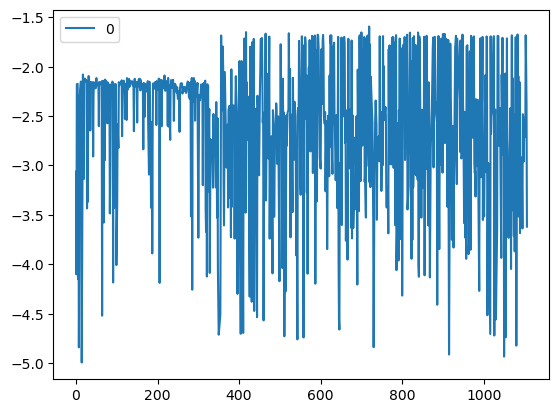

In [150]:
df_optimizer = pd.DataFrame([x['target'] for x in optimizer.res])
df_optimizer[df_optimizer[0] > -5].plot()

In [462]:
df_optimizer_params = pd.DataFrame([x['params'] for x in optimizer.res])
df_optimizer_target = pd.DataFrame([x['target'] for x in optimizer.res], columns=['target'])

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

In [463]:
df_optimizer.sort_values('target').tail(10)

,target,colsample_bytree,enabled_cfips_,enabled_cfips_microbusiness_density_rolling_mean_0,enabled_cfips_microbusiness_density_rolling_mean_1,enabled_cfips_microbusiness_density_rolling_mean_2,enabled_cfips_microbusiness_density_rolling_mean_3,enabled_cfips_target_mean_,enabled_cfips_target_median_,enabled_cfips_target_std_,enabled_county_,enabled_county_microbusiness_density_rolling_mean_0,enabled_county_microbusiness_density_rolling_mean_1,enabled_county_microbusiness_density_rolling_mean_2,enabled_county_microbusiness_density_rolling_mean_3,enabled_county_target_mean_,enabled_county_target_median_,enabled_county_target_std_,enabled_median_hh_inc_,enabled_median_hh_inc_target_mean_,enabled_median_hh_inc_target_median_,enabled_median_hh_inc_target_std_,enabled_pct_bb_,enabled_pct_bb_target_mean_,enabled_pct_bb_target_median_,enabled_pct_bb_target_std_,enabled_pct_college_,enabled_pct_college_target_mean_,enabled_pct_college_target_median_,enabled_pct_college_target_std_,enabled_pct_foreign_born_,enabled_pct_foreign_born_target_mean_,enabled_pct_foreign_born_target_median_,enabled_pct_foreign_born_target_std_,enabled_pct_it_workers_,enabled_pct_it_workers_target_mean_,enabled_pct_it_workers_target_median_,enabled_pct_it_workers_target_std_,enabled_state_,enabled_state_microbusiness_density_rolling_mean_0,enabled_state_microbusiness_density_rolling_mean_1,enabled_state_microbusiness_density_rolling_mean_2,enabled_state_microbusiness_density_rolling_mean_3,enabled_state_target_mean_,enabled_state_target_median_,enabled_state_target_std_,enabled_target_shift_0,enabled_target_shift_1,enabled_target_shift_2,enabled_target_shift_3,enabled_time_arrow_,learning_rate,num_iterations,num_leaves,params_cfips_microbusiness_density_rolling_mean_0,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_cfips_microbusiness_density_rolling_mean_3,params_county_microbusiness_density_rolling_mean_0,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_1,params_state_microbusiness_density_rolling_mean_2,params_state_microbusiness_density_rolling_mean_3,params_target_shift_0,params_target_shift_1,params_target_shift_2,params_target_shift_3,reg_alpha,reg_lambda,subsample
306,-2.126541,1.000000,0.000000,0.900000,0.900000,0.900000,0.900000,0.000000,0.000000,0.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.000000,0.900000,0.000000,0.900000,0.000000,0.000000,0.900000,0.900000,0.000000,0.900000,0.000000,0.900000,0.900000,0.000000,0.900000,0.900000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.900000,0.900000,0.000000,0.000000,0.900000,0.900000,0.900000,0.000000,0.900000,0.010000,941.424834,147.177007,1.000000,10.000000,1.000000,1.000000,10.000000,1.000000,10.000000,10.000000,7.505757,1.000000,10.000000,1.000000,1.000000,1.000000,10.000000,1.000000,22.242671,7.959892,1.000000
131,-2.125524,1.000000,0.900000,0.900000,0.000000,0.900000,0.900000,0.000000,0.000000,0.000000,0.000000,0.900000,0.900000,0.900000,0.900000,0.000000,0.900000,0.000000,0.900000,0.000000,0.900000,0.900000,0.900000,0.000000,0.000000,0.900000,0.900000,0.900000,0.000000,0.000000,0.900000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.900000,0.900000,0.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.900000,0.900000,0.000000,0.900000,0.010000,936.555420,106.945867,10.000000,6.142582,10.000000,1.000000,1.000000,10.000000,10.000000,4.914739,7.170397,1.000000,1.000000,1.000000,10.000000,1.000000,10.000000,1.000000,12.369415,14.165297,0.100000
191,-2.120261,1.000000,0.900000,0.000000,0.900000,0.900000,0.900000,0.000000,0.900000,0.760297,0.234021,0.900000,0.900000,0.900000,0.900000,0.000000,0.900000,0.000000,0.900000,0.277624,0.290582,0.900000,0.900000,0.170

In [178]:
df_optimizer.sort_values('target').tail(50)

,target,colsample_bytree,enabled_cfips_,enabled_cfips_target_mean_,enabled_cfips_target_median_,enabled_cfips_target_std_,enabled_county_,enabled_county_target_mean_,enabled_county_target_median_,enabled_county_target_std_,enabled_median_hh_inc_,enabled_pct_bb_,enabled_pct_college_,enabled_pct_foreign_born_,enabled_pct_it_workers_,enabled_state_,enabled_state_target_mean_,enabled_state_target_median_,enabled_state_target_std_,enabled_target_rolling_mean_0,enabled_target_rolling_mean_1,enabled_target_rolling_mean_2,enabled_target_rolling_mean_3,enabled_target_shift_0,enabled_target_shift_1,enabled_target_shift_2,enabled_target_shift_3,enabled_time_arrow_,learning_rate,num_iterations,num_leaves,params_target_rolling_mean_0,params_target_rolling_mean_1,params_target_rolling_mean_2,params_target_rolling_mean_3,params_target_shift_0,params_target_shift_1,params_target_shift_2,params_target_shift_3,reg_alpha,reg_lambda,subsample
26,-3.389954,0.141862,0.275770,0.498595,0.700372,0.585298,0.378627,0.568027,0.149829,0.176768,0.571863,0.457785,0.697322,0.323569,0.357209,0.510321,0.744330,0.715446,0.107949,0.447243,0.066740,0.675294,0.060321,0.021988,0.279293,0.310466,0.565591,0.341661,0.800081,721.780346,10.304734,7.003217,9.834280,6.609254,7.755720,8.469388,2.237433,2.727027,7.676395,35.161149,13.960581,0.465641
16,-3.372093,0.846442,0.407886,0.179882,0.250239,0.645398,0.396746,0.259328,0.468015,0.111009,0.556031,0.272908,0.387547,0.260001,0.642965,0.132401,0.651843,0.496386,0.136180,0.117452,0.194799,0.332750,0.708141,0.588453,0.216036,0.356780,0.031865,0.582027,0.646137,713.777755,122.590273,1.670575,5.715817,6.407264,6.574442,9.078828,3.972112,3.198479,4.941946,24.688123,34.064640,0.768953
58,-3.348894,0.117993,0.127900,0.006700,0.706575,0.372125,0.503017,0.206395,0.660846,0.194559,0.333508,0.150151,0.459300,0.078168,0.067740,0.331705,0.083626,0.497202,0.249095,0.571512,0.164268,0.108358,0.085389,0.194971,0.296838,0.094359,0.348314,0.409755,0.891946,388.135258,156.771308,4.551209,5.428956,8.772720,1.893957,8.906948,4.565480,1.640960,9.301912,7.030636,5.490840,0.772139
10,-3.219107,0.923861,0.189537,0.084778,0.706384,0.369983,0.353843,0.515885,0.612814,0.170180,0.151765,0.318374,0.635695,0.695341,0.142803,0.517094,0.334402,0.658583,0.221708,0.202653,0.016449,0.653513,0.124545,0.208898,0.184748,0.691539,0.061221,0.252494,0.615587,332.452125,117.643408,4.821914,1.118261,6.459426,4.122252,2.903742,9.776350,8.550840,5.038384,12.849962,0.563915,0.755263
22,-3.192370,0.693286,0.657491,0.722567,0.494355,0.482749,0.610840,0.257374,0.640568,0.625030,0.506225,0.406983,0.473876,0.192779,0.205575,0.731793,0.742109,0.621842,0.041548,0.551746,0.394233,0.403057,0.449014,0.352679,0.620261,0.219311,0.654127,0.213091,0.117537,684.766520,190.412329,6.309317,3.934704,3.722461,2.636587,7.437570,7.602913,8.421649,8.321878,29.254491,20.276826,0.376954
7,-3.054621,0.501213,0.335483,0.020646,0.209233,0.056378,0.035804,0.647689,0.535738,0.622828,0.099679,0.273965,0.684913,0.325041,0.694239,0.721026,0.004956,0.324698,0.437334,0.261621,0.282024,0.266866,0.173275,0.019528,0.548388,0.748887,0.028756,0.644324,0.494431,215.615967,18.419200,5.729045,1.941042,3.663977,3.473510,9.735451,5.226998,3.566630,9.444179,38.669067,28.775995,0.223191
28,-3.005178,0.293165,0.610426,0.153036,0.736384,0.003481,0.042427,0.736741,0.133832,0.515076,0.573815,0.191173,0.067801,0.424238,0.252322,0.134039,0.374712,0.102943,0.694965,0.739821,0.137255,0.175257,0.645741,0.566477,0.098259,0.050562,0.482801,0.636295,0.444798,655.153065,185.737183,9.591925,8.761836,2.591494,4.297580,3.237360,8.771160,4.298400,1.544607,8.220898,24.973970,0.609085
64,-2.924556,0.551944,0.035433,0.713005,0.037947,0.484061,0.133989,0.725764,0.701578,0.556907,0.236041,0.645809,0.354580,0.614924,0.330220,0.693709,0.662719,0.406726,0.264226,0.478343,0.282331,0.692433,0.172711,0.186034,0.691240,0.510794,0.238537,0.723661,0.466165,417.910872,188.266126,4.431311,7.421110,7.162096,2.977718,8.620525,7.069638,6.757685,8.05

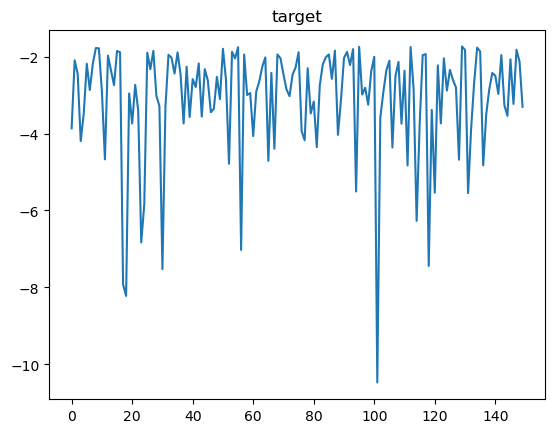

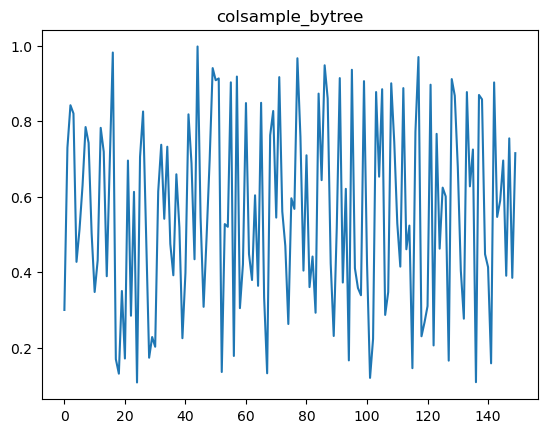

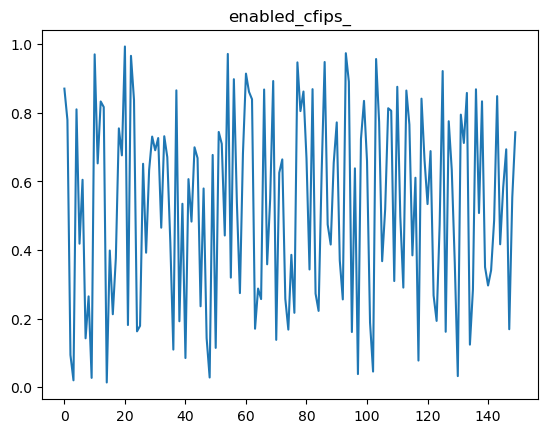

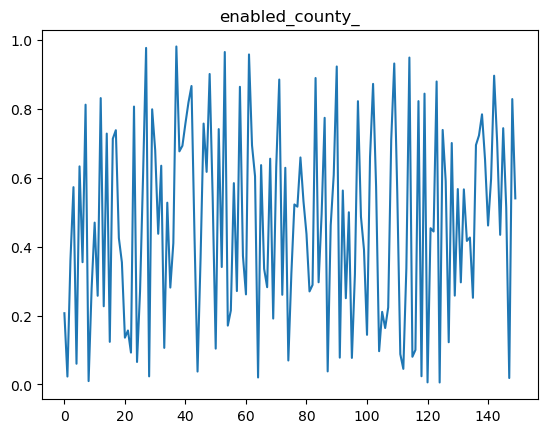

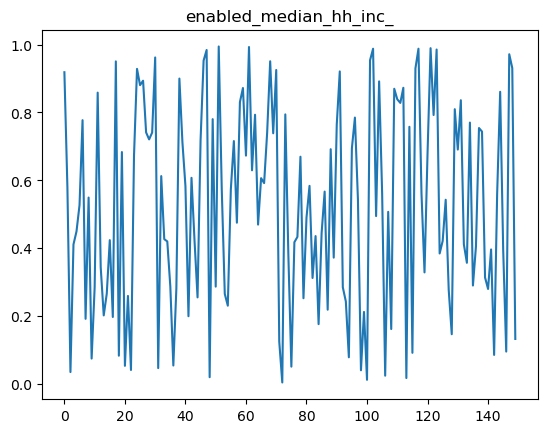

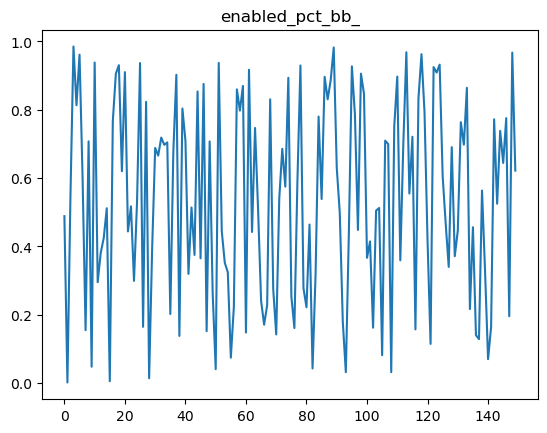

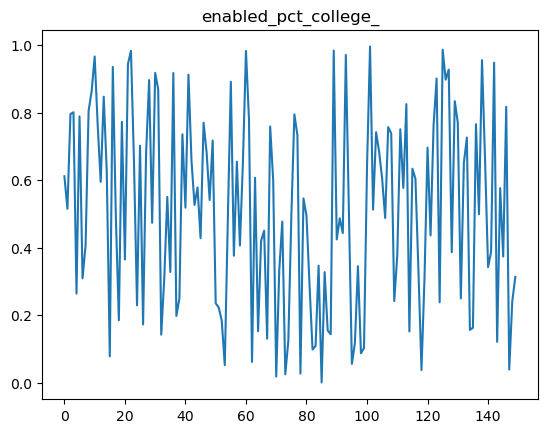

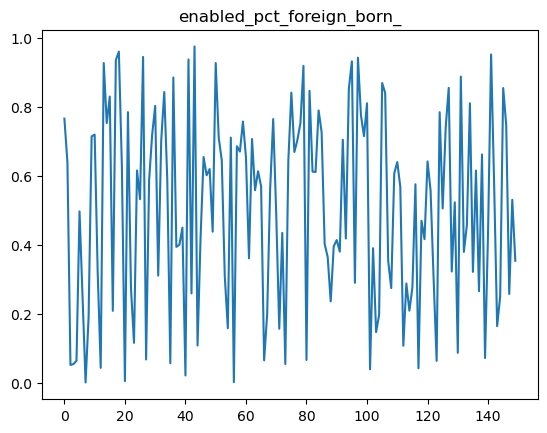

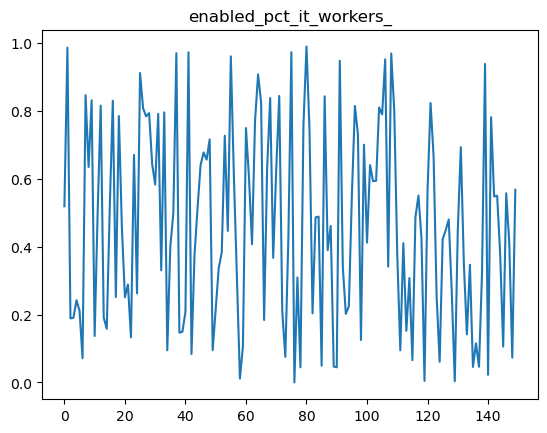

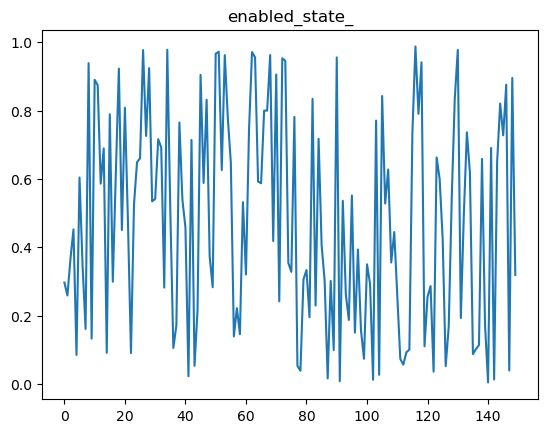

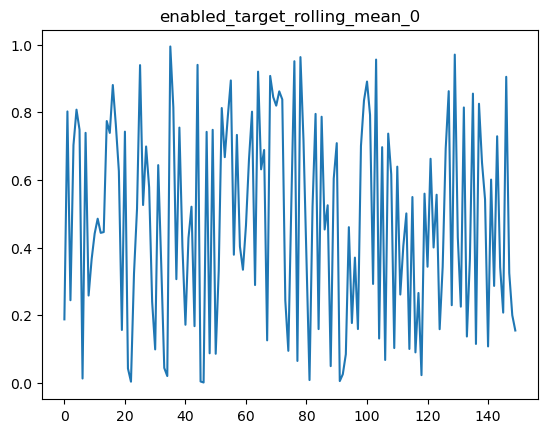

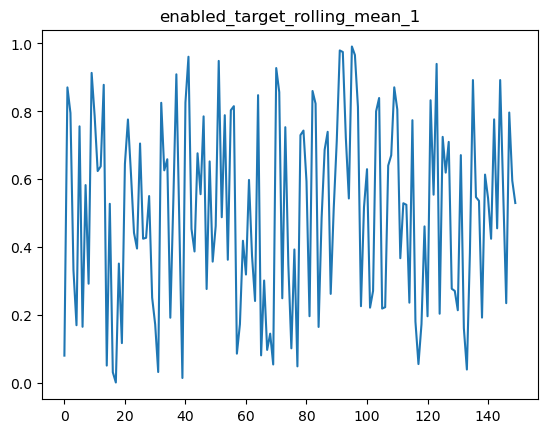

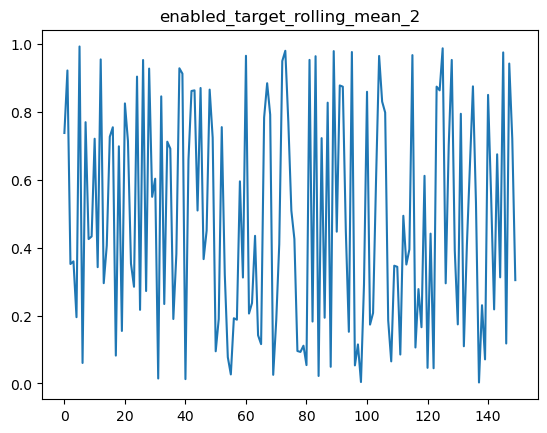

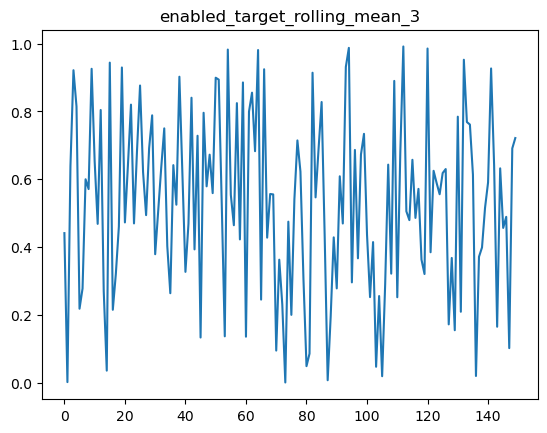

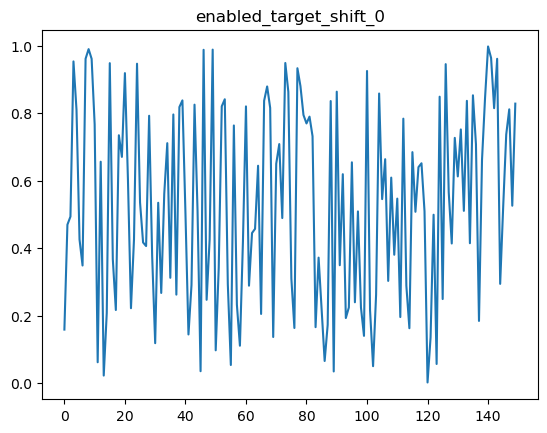

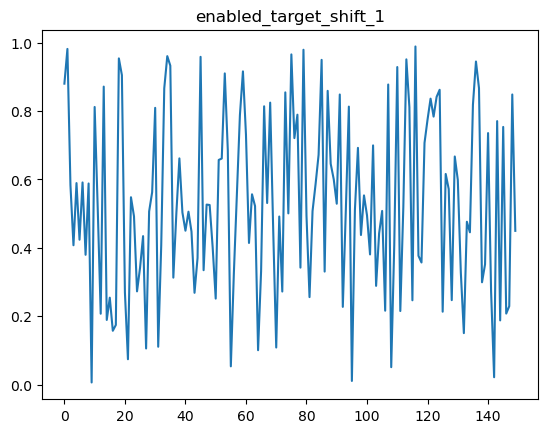

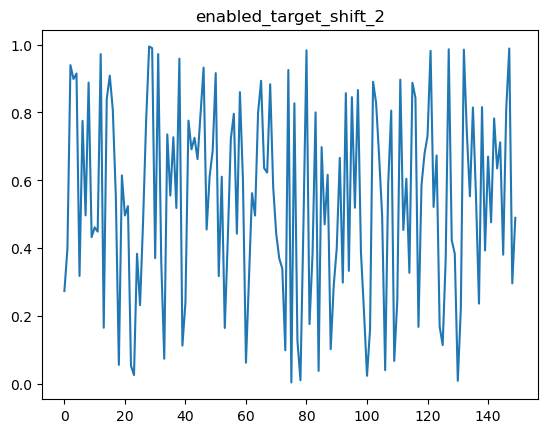

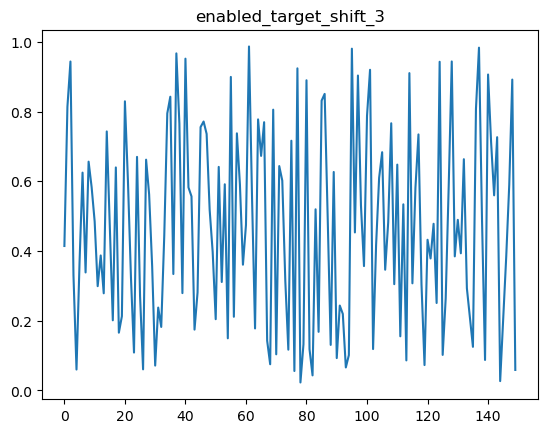

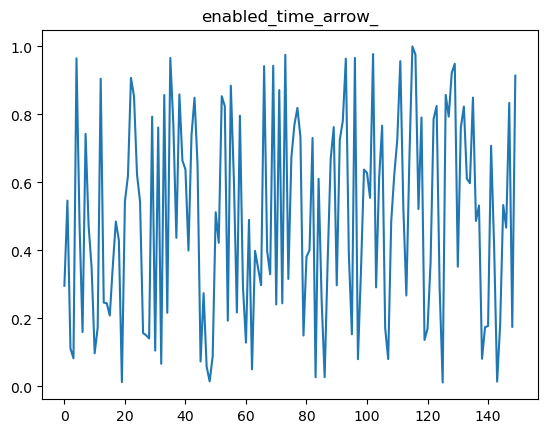

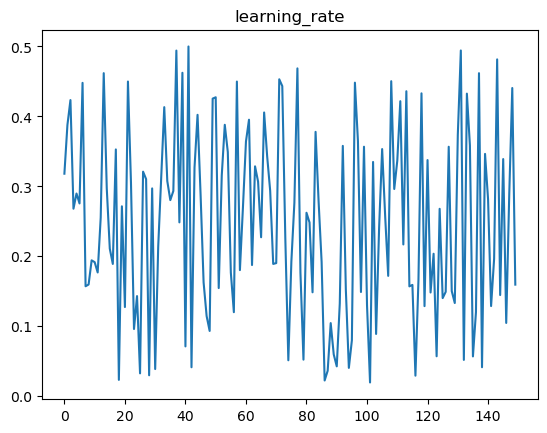

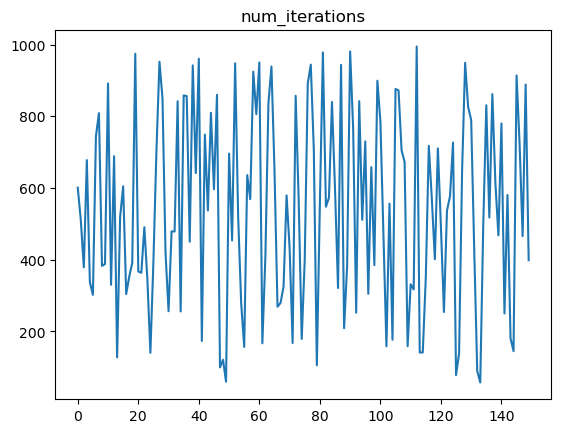

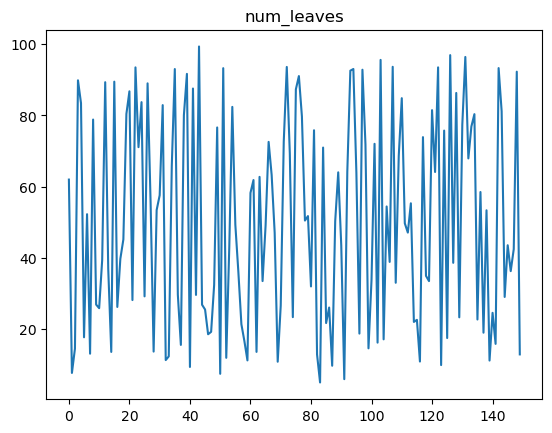

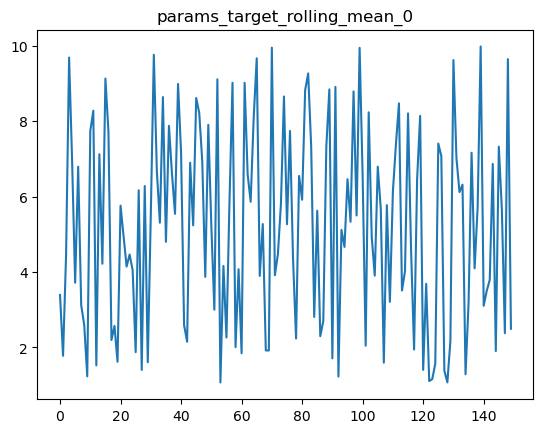

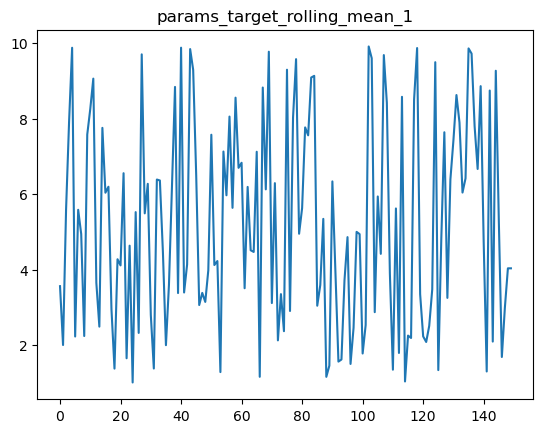

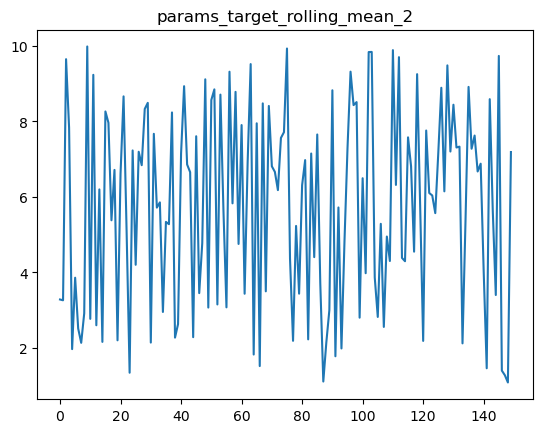

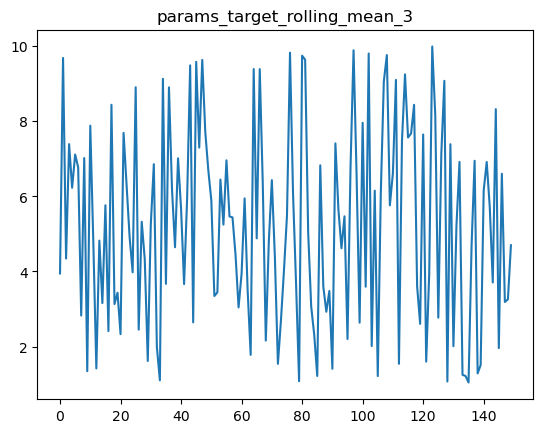

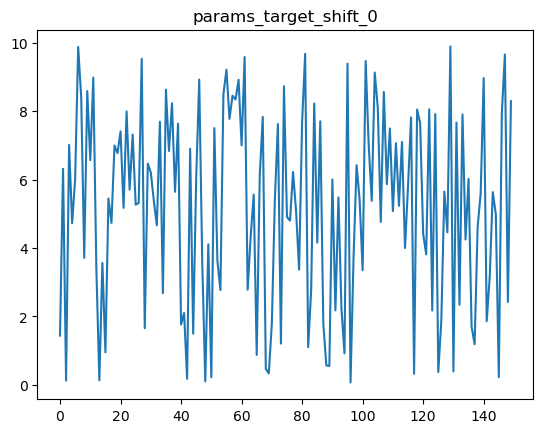

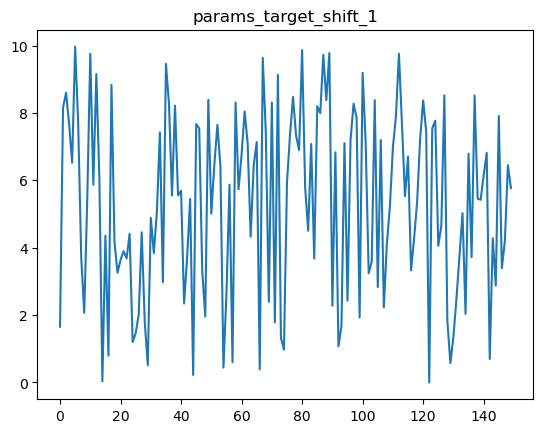

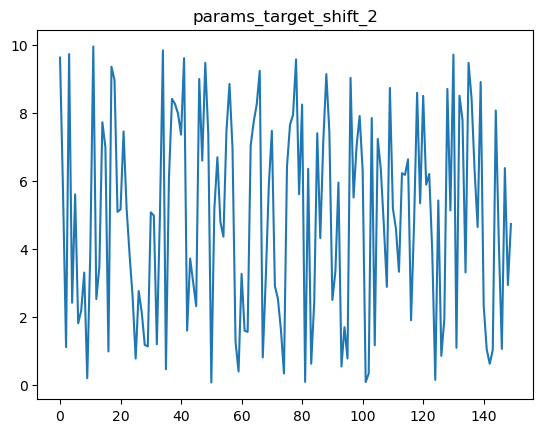

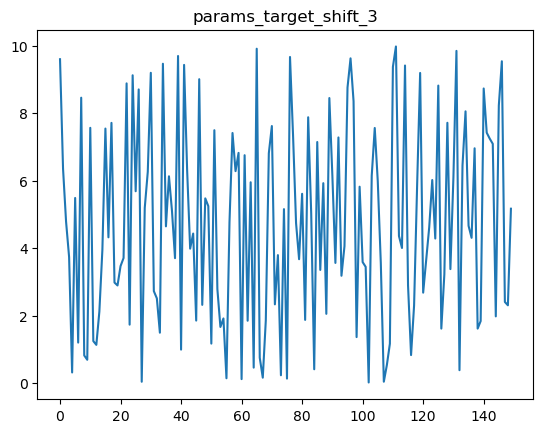

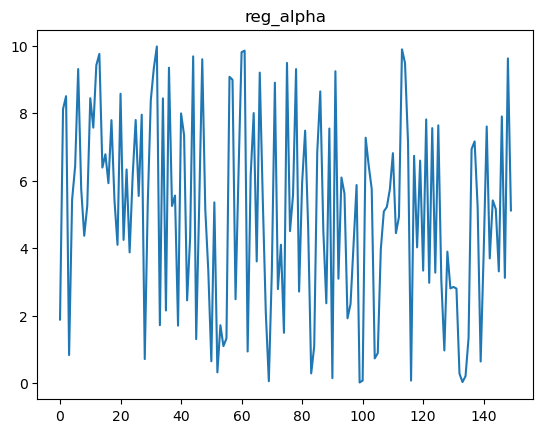

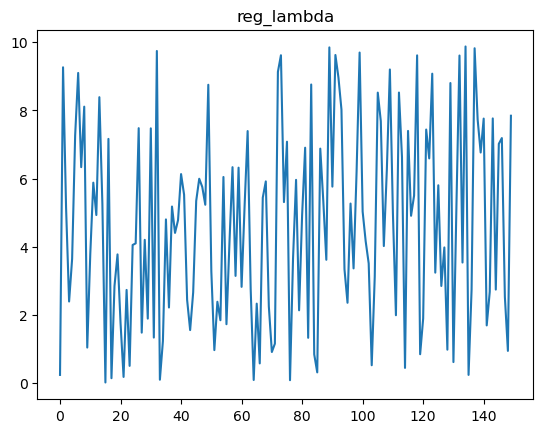

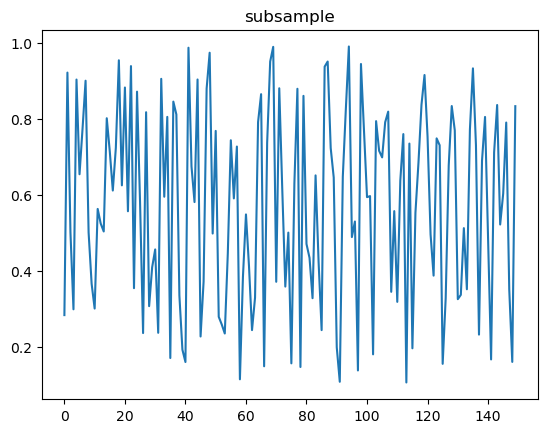

In [561]:
for label, content in df_optimizer.iteritems():
    ax = content.plot(title=label)
    plt.show()
    # break

In [149]:
params = optimizer.max['params']
print(optimizer.max['target'])
# params['num_iterations'] = 1000

lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
    manage_features, df_train, objective=objective, bayes_kwargs=params
)

recorded_evaluations = {}
callbacks = build_callbacks(log_evaluation=100, record_evaluation=recorded_evaluations)
# callbacks = build_callbacks(early_stopping=300, log_evaluation=0, record_evaluation=recorded_evaluations)

model_params = {
    **model_params,
    **{
        "boosting_type": "gbdt",
        # "objective": "mae",
        "objective": objective,
        "metric": "None",
        "first_metric_only": True,
        "num_threads": 6,
        "verbose": -1,
    },
}

    

gbm = lgb.train(
    model_params,
    lgb_train,
    # num_boost_round=500,
    callbacks=callbacks,
    valid_sets=[lgb_train, lgb_eval, lgb_test],
    feval=smape,
)
# gbm.best_score
gbm.best_score["valid_2"]["smape"]

# pred = gbm.predict(lgb_test.data)
# loss = smape(pred/manage_data_split.constant, lgb_test.label)
# print('test loss', loss)

-1.592836645753525


[100]	training's smape: 10.2492	valid_1's smape: 9.69847	valid_2's smape: 9.67788
[200]	training's smape: 3.35253	valid_1's smape: 3.04002	valid_2's smape: 3.07905
[300]	training's smape: 2.09795	valid_1's smape: 1.86526	valid_2's smape: 1.99186
[400]	training's smape: 1.86001	valid_1's smape: 1.65055	valid_2's smape: 1.82982
[500]	training's smape: 1.77793	valid_1's smape: 1.59461	valid_2's smape: 1.77521
[600]	training's smape: 1.7509	valid_1's smape: 1.58504	valid_2's smape: 1.77309
[700]	training's smape: 1.74258	valid_1's smape: 1.59299	valid_2's smape: 1.78372
[800]	training's smape: 1.72372	valid_1's smape: 1.59263	valid_2's smape: 1.78389


1.78485798401735

In [112]:
loss

('smape', 163.41544844404626, False)

####  Find biggest errors

In [336]:
params

{'colsample_bytree': 1.0,
 'enabled_cfips_': 0.0,
 'enabled_cfips_target_mean_': 0.9,
 'enabled_cfips_target_median_': 0.9,
 'enabled_cfips_target_std_': 0.9,
 'enabled_county_': 0.0,
 'enabled_county_target_mean_': 0.9,
 'enabled_county_target_median_': 0.0,
 'enabled_county_target_std_': 0.0,
 'enabled_median_hh_inc_': 0.0,
 'enabled_median_hh_inc_rolling_mean_0': 0.9,
 'enabled_median_hh_inc_rolling_mean_1': 0.0,
 'enabled_median_hh_inc_rolling_mean_2': 0.0,
 'enabled_median_hh_inc_rolling_mean_3': 0.9,
 'enabled_median_hh_inc_target_mean_': 0.9,
 'enabled_median_hh_inc_target_median_': 0.9,
 'enabled_median_hh_inc_target_std_': 0.9,
 'enabled_microbusiness_density_rolling_mean_0': 0.0,
 'enabled_microbusiness_density_rolling_mean_1': 0.9,
 'enabled_microbusiness_density_rolling_mean_2': 0.0,
 'enabled_microbusiness_density_rolling_mean_3': 0.9,
 'enabled_pct_bb_': 0.9,
 'enabled_pct_bb_rolling_mean_0': 0.0,
 'enabled_pct_bb_rolling_mean_1': 0.9,
 'enabled_pct_bb_rolling_mean_2': 0.

In [337]:
lgb_train.label

array([3.0192919, 3.0838373, 3.174679 , ..., 1.7675415, 1.8032495,
       1.8032495], dtype=float32)

In [338]:
lgb_train.data

,params_microbusiness_density_rolling_mean_1,params_microbusiness_density_rolling_mean_3,params_median_hh_inc_rolling_mean_0,params_median_hh_inc_rolling_mean_3,params_pct_bb_rolling_mean_1,params_pct_bb_rolling_mean_2,params_pct_college_rolling_mean_0,params_pct_college_rolling_mean_1,params_pct_foreign_born_rolling_mean_0,params_pct_foreign_born_rolling_mean_1,params_pct_foreign_born_rolling_mean_3,params_target_shift_0,params_target_shift_3,pct_bb,pct_college,time_arrow,cfips_target_median,cfips_target_mean,cfips_target_std,state_target_std,county_target_mean,median_hh_inc_target_median,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_college_target_mean,pct_foreign_born_target_mean,pct_it_workers_target_median,pct_it_workers_target_std
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001_2020-06-01,2.975162,3.004948,58786.000000,57051.5,78.9,78.9,15.20,15.20,2.05,2.0,2.05,3.004948,3.004948,78.9,15.9,0.263613,3.193804,3.164535,0.164113,1.584220,3.164535,3.012120,3.044592,0.099585,2.902557,3.717401,3.258550,2.447587,3.784229
1001_2020-07-01,2.976323,3.019292,58786.000000,57398.4,78.9,78.9,15.34,15.34,2.04,2.0,2.04,3.019292,3.019292,78.9,15.9,0.289542,3.193804,3.164535,0.164113,1.584220,3.164535,3.012120,3.044592,0.099585,2.902557,3.717401,3.258550,2.447587,3.784229
1001_2020-08-01,2.996220,3.083837,58786.000000,57745.3,78.9,78.9,15.48,15.48,2.03,2.0,2.03,3.083837,3.083837,78.9,15.9,0.316335,3.193804,3.164535,0.164113,1.584220,3.164535,3.012120,3.044592,0.099585,2.902557,3.717401,3.258550,2.447587,3.784229
1001_2020-09-01,3.008104,3.174679,58786.000000,58092.2,78.9,78.9,15.62,15.62,2.02,2.0,2.02,3.174679,3.174679,78.9,15.9,0.343129,3.193804,3.164535,0.164113,1.584220,3.164535,3.012120,3.044592,0.099585,2.902557,3.717401,3.258550,2.447587,3.784229
1001_2020-10-01,3.029356,3.205756,58786.000000,58439.1,78.9,78.9,15.76,15.76,2.01,2.0,2.01,3.205756,3.205756,78.9,15.9,0.369058,3.193804,3.164535,0.164113,1.584220,3.164535,3.012120,3.044592,0.099585,2.902557,3.717401,3.258550,2.447587,3.784229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-02-01,1.705416,1.749688,55798.333333,56661.2,79.7,79.7,13.33,13.33,1.76,2.3,1.76,1.749688,1.749688,79.7,12.7,0.790838,1.662198,1.663503,0.097177,17.233132,1.663503,1.486541,1.557172,0.173247,2.765957,2.902479,3.144045,1.672963,2.416517
56045_2022-03-01,1.707940,1.749688,54565.666667,56291.4,79.7,79.7,13.26,13.26,1.82,2.3,1.82,1.749688,1.749688,79.7,12.7,0.815039,1.662198,1.663503,0.097177,17.233132,1.663503,1.486541,1.557172,0.173247,2.765957,2.902479,3.144045,1.672963,2.416517
56045_2022-04-01,1.715842,1.767542,53333.000000,55921.6,79.7,79.7,13.19,13.19,1.88,2.3,1.88,1.767542,1.767542,79.7,12.7,0.841832,1.662198,1.663503,0.097177,17.233132,1.663503,1.486541,1.557172,0.173247,2.765957,2.902479,3.144045,1.672963,2.416517


In [188]:
gbm.best_score["valid_2"]["smape"]

1.5601088186018857

In [189]:
params

{'colsample_bytree': 0.9286896963822742,
 'enabled_cfips_': 0.6923001562662946,
 'enabled_cfips_target_mean_': 0.025611659512599833,
 'enabled_cfips_target_median_': 0.2954840953731328,
 'enabled_cfips_target_std_': 0.7151641067216267,
 'enabled_county_': 0.5279051568180759,
 'enabled_county_target_mean_': 0.3037961584109563,
 'enabled_county_target_median_': 0.2927638121375291,
 'enabled_county_target_std_': 0.37429764217995953,
 'enabled_median_hh_inc_': 0.7388612563084038,
 'enabled_pct_bb_': 0.40068432360205625,
 'enabled_pct_college_': 0.28888420423885197,
 'enabled_pct_foreign_born_': 0.7027459628583262,
 'enabled_pct_it_workers_': 0.5588135085974917,
 'enabled_state_': 0.6960785343154164,
 'enabled_state_target_mean_': 0.13526701289202575,
 'enabled_state_target_median_': 0.42186883808817904,
 'enabled_state_target_std_': 0.5219725143993087,
 'enabled_target_rolling_mean_0': 0.18300178029263856,
 'enabled_target_rolling_mean_1': 0.6304547295229233,
 'enabled_target_rolling_mean_

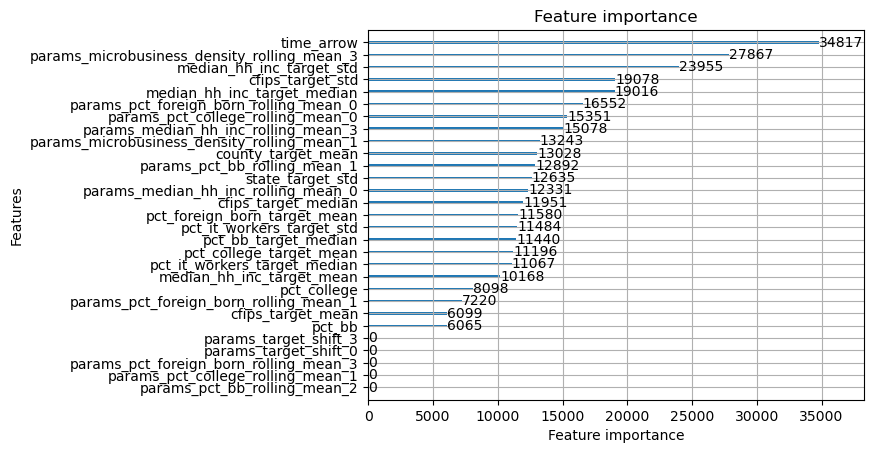

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

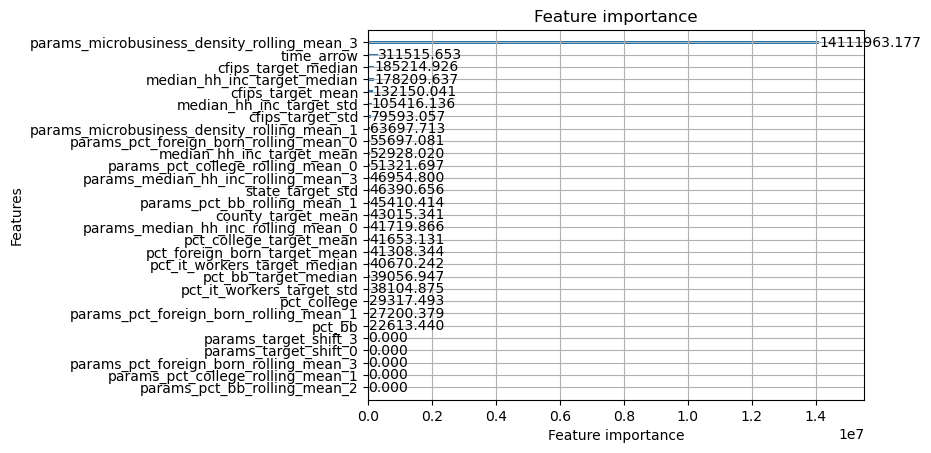

In [341]:
lgb.plot_importance(gbm, ignore_zero=False)
plt.show()
lgb.plot_importance(gbm, importance_type='gain', ignore_zero=False)

In [352]:
import PIL.Image as Image
import io
ax = lgb.create_tree_digraph(gbm, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count', 'data_percentage'])
b = ax._repr_image_png()
image = Image.open(io.BytesIO(b))
image.save('tree.png')

In [353]:
df_features = manage_features.generate_features(params)
df_target = manage_features.generate_target(df_train)

In [373]:
data = lgb_test.data.copy()
data['label'] = lgb_test.label.copy()
data['pred'] = gbm.predict(lgb_test.data)

In [374]:
def smape(pred, eval_data):
    if hasattr(eval_data, "label"):
        A = eval_data.label  # Used by lightgbm
    else:
        A = eval_data  # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        print(type(pred), pred)
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

In [375]:
data['smape'] = data.apply(lambda row: smape(float(row['pred']), row['label'])[1], axis=1)

In [380]:
data

,params_microbusiness_density_rolling_mean_1,params_microbusiness_density_rolling_mean_3,params_median_hh_inc_rolling_mean_0,params_median_hh_inc_rolling_mean_3,params_pct_bb_rolling_mean_1,params_pct_bb_rolling_mean_2,params_pct_college_rolling_mean_0,params_pct_college_rolling_mean_1,params_pct_foreign_born_rolling_mean_0,params_pct_foreign_born_rolling_mean_1,params_pct_foreign_born_rolling_mean_3,params_target_shift_0,params_target_shift_3,pct_bb,pct_college,time_arrow,cfips_target_median,cfips_target_mean,cfips_target_std,state_target_std,county_target_mean,median_hh_inc_target_median,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_college_target_mean,pct_foreign_born_target_mean,pct_it_workers_target_median,pct_it_workers_target_std,label,pred,smape
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001_2022-09-01,3.334861,3.423852,57982.0,58131.8,82.7,82.7,16.58,16.58,2.30,2.3,2.30,3.423852,3.423852,82.7,16.7,0.974071,3.193804,3.164535,0.164113,1.584220,3.164535,3.301616,3.273837,0.117618,3.635816,5.019801,3.144045,1.899649,2.796420,3.442677,3.466408,0.686946
1001_2022-10-01,3.359034,3.442677,57982.0,58056.9,82.7,82.7,16.64,16.64,2.30,2.3,2.30,3.442677,3.442677,82.7,16.7,1.000000,3.193804,3.164535,0.164113,1.584220,3.164535,3.301616,3.273837,0.117618,3.635816,5.019801,3.144045,1.899649,2.796420,3.463856,3.466159,0.066479
1003_2022-09-01,8.079126,8.491150,61756.0,61068.8,85.1,85.1,20.36,20.36,3.46,3.4,3.46,8.491150,8.491150,85.1,20.2,0.974071,7.909001,7.889811,0.365452,1.584220,5.071356,8.160435,8.166215,0.318309,6.229026,8.343516,3.589959,2.519980,3.744905,8.341701,8.372881,0.373088
1003_2022-10-01,8.123236,8.341701,61756.0,61412.4,85.1,85.1,20.28,20.28,3.43,3.4,3.43,8.341701,8.341701,85.1,20.2,1.000000,7.909001,7.889811,0.365452,1.584220,5.071356,8.160435,8.166215,0.318309,6.229026,8.343516,3.589959,2.519980,3.744905,8.359798,8.372426,0.150939
1005_2022-09-01,1.187760,1.196728,34990.0,34497.0,64.6,64.6,7.36,7.36,2.62,2.6,2.62,1.196728,1.196728,64.6,7.3,0.974071,1.102025,1.102521,0.077298,1.584220,0.973607,1.196728,1.201272,0.014567,1.486266,1.443375,3.349003,2.447587,3.784229,1.206827,1.210069,0.268286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56041_2022-10-01,3.931784,3.995591,72458.0,71552.5,91.4,91.4,12.45,12.45,2.90,2.9,2.90,3.995591,3.995591,91.4,12.6,1.000000,3.954258,3.946930,0.373384,17.233132,3.946930,3.978369,3.954946,0.088069,11.732983,2.756952,4.539328,3.466130,4.606017,4.009369,4.038035,0.712433
56043_2022-09-01,3.066593,3.209264,57306.0,56676.4,82.8,82.8,15.08,15.08,2.08,2.2,2.08,3.209264,3.209264,82.8,15.0,0.974071,2.977668,2.904894,0.234460,17.233132,2.904894,3.076923,3.088503,0.104056,4.857717,4.563565,3.108843,2.294703,5.358513,3.209264,3.225056,0.490887
56043_2022-10-01,3.081684,3.209264,57306.0,56991.2,82.8,82.8,15.04,15.04,2.14,2.2,2.14,3.209264,3.209264,82.8,15.0,1.000000,2.977668,2.904894,0.234460,17.233132,2.904894,3.076923,3.088503,0.104056,4.857717,4.563565,3.108843,2.294703,5.358513,3.126551,3.224851,3.095385


In [387]:
data.sort_values('smape')[:-2]['smape'].mean()

1.4704516473056175

In [390]:
data.sort_values('smape').tail(50)

,params_microbusiness_density_rolling_mean_1,params_microbusiness_density_rolling_mean_3,params_median_hh_inc_rolling_mean_0,params_median_hh_inc_rolling_mean_3,params_pct_bb_rolling_mean_1,params_pct_bb_rolling_mean_2,params_pct_college_rolling_mean_0,params_pct_college_rolling_mean_1,params_pct_foreign_born_rolling_mean_0,params_pct_foreign_born_rolling_mean_1,params_pct_foreign_born_rolling_mean_3,params_target_shift_0,params_target_shift_3,pct_bb,pct_college,time_arrow,cfips_target_median,cfips_target_mean,cfips_target_std,state_target_std,county_target_mean,median_hh_inc_target_median,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_college_target_mean,pct_foreign_born_target_mean,pct_it_workers_target_median,pct_it_workers_target_std,label,pred,smape
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48155_2022-10-01,12.531014,9.778226,39306.0,39737.9,69.0,69.0,9.73,9.73,3.18,3.1,3.18,9.778226,9.778226,69.0,9.5,1.000000,6.034483,6.274484,4.791509,2.862787,6.274484,13.306451,12.096774,1.864843,2.241066,2.076369,3.498365,1.672963,2.416517,8.971774,10.279501,13.585876
5013_2022-09-01,0.311945,0.333810,50441.0,49636.2,67.7,67.7,5.96,5.96,1.66,1.8,1.66,0.333810,0.333810,67.7,5.6,0.974071,0.378788,0.414909,0.099615,1.497099,1.437358,2.198666,1.391680,0.998158,1.666610,0.817337,2.501120,2.115562,1.970910,0.333810,0.291254,13.616679
30103_2022-10-01,1.376857,1.473297,44671.0,44508.6,70.6,70.6,23.88,23.88,0.31,0.0,0.31,1.473297,1.473297,70.6,24.2,1.000000,1.245552,1.174972,0.274829,2.897668,1.174972,1.567933,1.486043,0.182735,2.000280,7.674601,1.581170,2.294703,5.358513,1.289134,1.477756,13.634224
10003_2022-10-01,18.615428,20.628910,75275.0,75136.7,89.1,89.1,21.08,21.08,11.50,11.5,11.50,20.628910,20.628910,89.1,21.1,1.000000,17.694836,18.231214,4.137013,14.402883,18.231214,18.837944,18.956308,1.266763,7.918230,8.122901,6.841351,2.743426,3.403900,20.917912,24.014092,13.781628
20065_2022-10-01,2.572875,4.871795,40890.0,41438.5,77.7,77.7,20.40,20.40,0.89,0.8,0.89,4.871795,4.871795,77.7,20.5,1.000000,2.307692,3.053721,1.398424,1.532490,2.459451,3.436019,3.180813,0.824533,2.940711,5.490425,2.001531,8.735909,5.804309,5.282051,4.598900,13.827646
8025_2022-10-01,0.856652,0.834691,40785.0,40920.0,77.8,77.8,5.40,5.40,3.76,3.8,3.76,0.834691,0.834691,77.8,5.2,1.000000,0.813347,0.809695,0.088816,9.564177,0.809695,0.824511,0.861156,0.062233,2.795677,0.845110,4.174634,4.193719,3.569081,0.956840,0.832746,13.868461
31049_2022-09-01,3.787115,4.332634,48958.0,48623.8,82.1,82.1,14.86,14.86,1.12,1.0,1.12,4.332634,4.332634,82.1,15.5,0.974071,3.779841,3.661102,0.495032,2.356638,2.809439,3.679734,3.791357,0.437847,4.196978,3.552992,2.111696,1.727212,1.683636,4.961565,4.316035,13.915885
1133_2022-10-01,1.868814,3.597542,40991.0,40470.7,71.4,71.4,7.84,7.84,1.32,1.3,1.32,3.597542,3.597542,71.4,7.9,1.000000,1.219642,1.433771,0.694806,1.584220,1.346686,1.247748,2.099714,1.171596,2.400208,1.658719,2.297108,3.434500,3.871271,3.555155,3.090185,13.993868
12131_2022-10-01,25.937606,28.861149,67390.0,66460.3,86.3,86.3,19.82,19.82,6.63,6.7,6.63,28.861149,28.861149,86.3,19.9,1.000000,19.398479,21.533259,3.611749,5.678573,15.159115,25.771346,26.239900,1.476336,4.757620,5.855310,5.085377,2.105498,3.821091,28.979614,25.165029,14.090351


In [383]:
data[data['pred'] < 0.02]

,params_microbusiness_density_rolling_mean_1,params_microbusiness_density_rolling_mean_3,params_median_hh_inc_rolling_mean_0,params_median_hh_inc_rolling_mean_3,params_pct_bb_rolling_mean_1,params_pct_bb_rolling_mean_2,params_pct_college_rolling_mean_0,params_pct_college_rolling_mean_1,params_pct_foreign_born_rolling_mean_0,params_pct_foreign_born_rolling_mean_1,params_pct_foreign_born_rolling_mean_3,params_target_shift_0,params_target_shift_3,pct_bb,pct_college,time_arrow,cfips_target_median,cfips_target_mean,cfips_target_std,state_target_std,county_target_mean,median_hh_inc_target_median,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_college_target_mean,pct_foreign_born_target_mean,pct_it_workers_target_median,pct_it_workers_target_std,label,pred,smape
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28055_2022-09-01,0.0,0.0,28333.0,27508.0,33.3,33.3,0.86,0.86,0.0,0.0,0.0,0.0,0.0,33.3,0.9,0.974071,0.0,0.063846,0.076347,1.539697,0.063846,0.361836,0.216409,0.202955,0.0,0.0,1.58117,1.672963,2.416517,0.0,0.002248,200.0
28055_2022-10-01,0.0,0.0,28333.0,27920.5,33.3,33.3,0.88,0.88,0.0,0.0,0.0,0.0,0.0,33.3,0.9,1.000000,0.0,0.063846,0.076347,1.539697,0.063846,0.361836,0.216409,0.202955,0.0,0.0,1.58117,1.672963,2.416517,0.0,0.002248,200.0


In [376]:
# cfips_avg_error = data.groupby('cfips')['smape'].mean().sort_values()

KeyError: 'cfips'

In [ ]:
# cfips_avg_error[:-50].mean()

In [379]:
# t1 = data[data['cfips'].isin(cfips_avg_error[-50:].index)].copy()
# print('current:', t1['smape'].mean())
# t1['pred'] = t1['pred'] * 1.03
# t1['smape'] = t1.apply(lambda row: smape(row['pred'], row['label'])[1], axis=1)
# print('adjusted:', t1['smape'].mean())

In [257]:
t1.sort_values('smape')

,params_target_rolling_mean_1,params_target_rolling_mean_2,params_target_shift_3,county,state,cfips,median_hh_inc,pct_foreign_born,pct_it_workers,cfips_target_std,state_target_std,label,pred,smape
row_id,,,,,,,,,,,,,,
47103_2022-09-01,5.088004,5.101195,5.088004,Lincoln County,Tennessee,47103,53923.0,2.6,0.3,0.499424,3.697826,5.088004,5.093353,0.105088
19065_2022-09-01,2.287306,2.303505,2.287306,Fayette County,Iowa,19065,49834.0,1.3,0.9,0.282183,3.966038,2.287306,2.290538,0.141203
54053_2022-09-01,1.453722,1.434842,1.453722,Mason County,West Virginia,54053,51820.0,1.3,1.0,0.171572,1.241438,1.449002,1.452237,0.223024
48035_2022-10-01,3.666758,4.526692,3.666758,Bosque County,Texas,48035,57337.0,7.0,1.6,0.931303,2.862787,3.708035,3.699457,0.231598
54077_2022-10-01,1.656770,1.928011,1.656770,Preston County,West Virginia,54077,51992.0,1.3,1.6,0.428771,1.241438,1.660435,1.656031,0.265590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001_2022-09-01,46.253883,45.332870,46.253883,Alachua County,Florida,12001,50089.0,10.8,1.9,12.909924,5.678573,7.911023,41.248656,135.629989
56033_2022-10-01,128.262240,120.851965,128.262240,Sheridan County,Wyoming,56033,59380.0,2.5,1.8,40.598497,17.233132,227.756653,35.139108,146.535300
29063_2022-10-01,1.323290,1.313111,1.323290,DeKalb County,Missouri,29063,58433.0,0.6,0.8,1.660972,1.952608,11.553339,1.324683,158.854465


In [261]:
df_train[df_train['cfips'] == 12001]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
12402,12001_2019-08-01,12001,Alachua County,Florida,2019-08-01,12.222383,26047,2019,45478.0,81.4,21.1,10.0,2.0,8
12403,12001_2019-09-01,12001,Alachua County,Florida,2019-09-01,14.885810,31723,2019,45478.0,81.4,21.1,10.0,2.0,9
12404,12001_2019-10-01,12001,Alachua County,Florida,2019-10-01,15.124186,32231,2019,45478.0,81.4,21.1,10.0,2.0,10
12405,12001_2019-11-01,12001,Alachua County,Florida,2019-11-01,15.385554,32788,2019,45478.0,81.4,21.1,10.0,2.0,11
12406,12001_2019-12-01,12001,Alachua County,Florida,2019-12-01,15.546035,33130,2019,45478.0,81.4,21.1,10.0,2.0,12
12407,12001_2020-01-01,12001,Alachua County,Florida,2020-01-01,15.479798,33402,2020,49078.0,83.7,21.7,10.3,2.0,1
12408,12001_2020-02-01,12001,Alachua County,Florida,2020-02-01,7.728777,16677,2020,49078.0,83.7,21.7,10.3,2.0,2
12409,12001_2020-03-01,12001,Alachua County,Florida,2020-03-01,7.735728,16692,2020,49078.0,83.7,21.7,10.3,2.0,3
12410,12001_2020-04-01,12001,Alachua County,Florida,2020-04-01,7.765389,16756,2020,49078.0,83.7,21.7,10.3,2.0,4
12411,12001_2020-05-01,12001,Alachua County,Florida,2020-05-01,7.772340,16771,2020,49078.0,83.7,21.7,10.3,2.0,5


In [232]:
data.groupby('cfips')['smape'].mean().mean()

1.5601088186018857

In [228]:
data[data['cfips'] == 28055]

,params_target_rolling_mean_1,params_target_rolling_mean_2,params_target_shift_3,county,state,cfips,median_hh_inc,pct_foreign_born,pct_it_workers,cfips_target_std,state_target_std,label,pred,smape
row_id,,,,,,,,,,,,,,
28055_2022-09-01,0.0,0.0,0.0,Issaquena County,Mississippi,28055,28333.0,0.0,0.0,0.076347,1.539697,0.0,0.094491,200.0
28055_2022-10-01,0.0,0.0,0.0,Issaquena County,Mississippi,28055,28333.0,0.0,0.0,0.076347,1.539697,0.0,0.094491,200.0


In [209]:
data

,params_target_rolling_mean_1,params_target_rolling_mean_2,params_target_shift_3,county,state,cfips,median_hh_inc,pct_foreign_born,pct_it_workers,cfips_target_std,state_target_std,label,pred
row_id,,,,,,,,,,,,,
1001_2022-09-01,3.423852,3.430911,3.423852,Autauga County,Alabama,1001,57982.0,2.3,0.6,0.164113,1.584220,3.442677,3.418403
1001_2022-10-01,3.442677,3.433264,3.442677,Autauga County,Alabama,1001,57982.0,2.3,0.6,0.164113,1.584220,3.463856,3.433773
1003_2022-09-01,8.491150,8.532307,8.491150,Baldwin County,Alabama,1003,61756.0,3.4,1.0,0.365452,1.584220,8.341701,8.558766
1003_2022-10-01,8.341701,8.416425,8.341701,Baldwin County,Alabama,1003,61756.0,3.4,1.0,0.365452,1.584220,8.359798,8.275013
1005_2022-09-01,1.196728,1.206827,1.196728,Barbour County,Alabama,1005,34990.0,2.6,1.1,0.077298,1.584220,1.206827,1.191118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56041_2022-10-01,3.995591,3.985258,3.995591,Uinta County,Wyoming,56041,72458.0,2.9,1.7,0.373384,17.233132,4.009369,3.979173
56043_2022-09-01,3.209264,3.217535,3.209264,Washakie County,Wyoming,56043,57306.0,2.2,0.9,0.234460,17.233132,3.209264,3.170026
56043_2022-10-01,3.209264,3.209264,3.209264,Washakie County,Wyoming,56043,57306.0,2.2,0.9,0.234460,17.233132,3.126551,3.170026


In [207]:
smape(data['pred'].values, lgb_test.label)

('smape', 1.5601088186018857, False)

In [392]:
df_train.head(50)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,55317.0,76.6,14.5,2.1,1.3,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,55317.0,76.6,14.5,2.1,1.3,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,55317.0,76.6,14.5,2.1,1.3,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,12
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,58786.0,78.9,15.9,2.0,1.1,1
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,58786.0,78.9,15.9,2.0,1.1,2
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,58786.0,78.9,15.9,2.0,1.1,3
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,58786.0,78.9,15.9,2.0,1.1,4
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,58786.0,78.9,15.9,2.0,1.1,5


In [629]:
t0 = df_features[df_features.isna().any(axis=1)]
t0

,params_target_rolling_mean_0,params_target_rolling_mean_2,params_target_shift_0,params_target_shift_1,params_target_shift_2,state,pct_bb,pct_college,pct_it_workers,time_arrow
row_id,,,,,,,,,,
1001_2019-08-01,NaN,NaN,NaN,NaN,3.007682,Alabama,76.6,14.5,1.3,0.000000
1001_2019-09-01,NaN,NaN,NaN,NaN,2.884870,Alabama,76.6,14.5,1.3,0.026793
1001_2019-10-01,NaN,NaN,3.007682,3.007682,3.055843,Alabama,76.6,14.5,1.3,0.052723
1001_2019-11-01,2.985407,NaN,2.884870,2.884870,2.993233,Alabama,76.6,14.5,1.3,0.079516
1001_2019-12-01,2.981795,NaN,3.055843,3.055843,2.993233,Alabama,76.6,14.5,1.3,0.105445
...,...,...,...,...,...,...,...,...,...,...
56045_2019-08-01,NaN,NaN,NaN,NaN,1.548594,Wyoming,71.1,14.1,0.6,0.000000
56045_2019-09-01,NaN,NaN,NaN,NaN,1.530794,Wyoming,71.1,14.1,0.6,0.026793
56045_2019-10-01,NaN,NaN,1.548594,1.548594,1.530794,Wyoming,71.1,14.1,0.6,0.052723


In [469]:
lgb_train.label

array([2.88487  , 3.055843 , 2.9932332, ..., 1.6885216, 1.6525956,
       1.6525956], dtype=float32)

In [630]:
pd.merge(df_target.rename('shifted_target'), df_train.set_index('row_id'), 'left', left_index=True, right_index=True)

,shifted_target,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
row_id,,,,,,,,,,,,,,
1001_2019-08-01,3.007682,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,55317.0,76.6,14.5,2.1,1.3,8
1001_2019-09-01,2.884870,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,55317.0,76.6,14.5,2.1,1.3,9
1001_2019-10-01,3.055843,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,55317.0,76.6,14.5,2.1,1.3,10
1001_2019-11-01,2.993233,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,11
1001_2019-12-01,2.993233,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,55317.0,76.6,14.5,2.1,1.3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-06-01,1.803249,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,6
56045_2022-07-01,1.803249,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,7
56045_2022-08-01,1.785395,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,8


In [473]:
t0 = lgb_test.data
t0[t0.isna().any(axis=1)]

,params_target_rolling_mean_0,params_target_rolling_mean_1,params_target_rolling_mean_3,params_target_shift_2,params_target_shift_3,state,median_hh_inc,pct_college,pct_foreign_born,pct_it_workers,time_arrow
row_id,,,,,,,,,,,
48243_2022-03-01,5.477308,5.432321,5.447399,5.630027,5.477308,Texas,NaN,14.3,10.1,0.0,0.815039
48243_2022-04-01,5.451226,5.412792,5.431124,5.683646,5.425143,Texas,NaN,14.3,10.1,0.0,0.841832
48243_2022-05-01,5.451226,5.425143,5.423544,5.522788,5.477308,Texas,NaN,14.3,10.1,0.0,0.867761
48243_2022-06-01,5.425143,5.446009,5.416449,5.522788,5.372979,Texas,NaN,14.3,10.1,0.0,0.894555
48243_2022-07-01,5.425143,5.446009,5.451226,5.415550,5.477308,Texas,NaN,14.3,10.1,0.0,0.920484
48243_2022-08-01,5.399061,5.414710,5.425143,5.268649,5.320814,Texas,NaN,14.3,10.1,0.0,0.947277
48243_2022-09-01,5.242566,5.362546,5.372979,5.477308,5.164319,Texas,NaN,14.3,10.1,0.0,0.974071
48243_2022-10-01,5.164319,5.299948,5.329508,5.477308,5.164319,Texas,NaN,14.3,10.1,0.0,1.000000


In [471]:
df_train[df_train['row_id'].isin(lgb_test.data.index)]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
31,1001_2022-03-01,1001,Autauga County,Alabama,2022-03-01,3.336785,1418,2022,57982.0,82.7,16.7,2.3,0.6,3
32,1001_2022-04-01,1001,Autauga County,Alabama,2022-04-01,3.372082,1433,2022,57982.0,82.7,16.7,2.3,0.6,4
33,1001_2022-05-01,1001,Autauga County,Alabama,2022-05-01,3.313253,1408,2022,57982.0,82.7,16.7,2.3,0.6,5
34,1001_2022-06-01,1001,Autauga County,Alabama,2022-06-01,3.346197,1422,2022,57982.0,82.7,16.7,2.3,0.6,6
35,1001_2022-07-01,1001,Autauga County,Alabama,2022-07-01,3.437971,1461,2022,57982.0,82.7,16.7,2.3,0.6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,6
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,53333.0,79.7,12.7,2.3,0.0,7
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,8
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,53333.0,79.7,12.7,2.3,0.0,9


##### NNI

In [117]:
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector

# load data
...
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x = lgb_train.data.drop(columns=['state', 'county', 'cfips'])
y = lgb_train.label

# initlize a selector
fgs = FeatureGradientSelector()
# fit data
fgs.fit(x.reset_index(drop=True), y)
# get improtant features
# will return the index with important feature here.
print(fgs.get_selected_features())

TypeError: type not understood

In [119]:
# Copyright (c) Microsoft Corporation
# All rights reserved.
#
# MIT License
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and
# to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED *AS IS*, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING
# BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
# DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import bz2
import urllib.request
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector

url_zip_train = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_train.binary.bz2'
urllib.request.urlretrieve(url_zip_train, filename='train.bz2')

f_svm = open('train.svm', 'wt')
with bz2.open('train.bz2', 'rb') as f_zip:
    data = f_zip.read()
    f_svm.write(data.decode('utf-8'))
f_svm.close()

X, y = load_svmlight_file('train.svm')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 20,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0}

eval_ratio = 0.1
early_stopping_rounds = 10
importance_type = 'gain'
num_boost_round = 1000
topk = 10

selector = GBDTSelector()
selector.fit(X_train, y_train,
             lgb_params = lgb_params,
             eval_ratio = eval_ratio,
             early_stopping_rounds = early_stopping_rounds,
             importance_type = importance_type,
             num_boost_round = num_boost_round)

print("selected features\t", selector.get_selected_features(topk=topk))



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 0.953524	valid_0's l1: 0.975613
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.903599	valid_0's l1: 0.949122
[3]	valid_0's l2: 0.858907	valid_0's l1: 0.924225
[4]	valid_0's l2: 0.816762	valid_0's l1: 0.899857
[5]	valid_0's l2: 0.780069	valid_0's l1: 0.877336
[6]	valid_0's l2: 0.746674	valid_0's l1: 0.85606
[7]	valid_0's l2: 0.713151	valid_0's l1: 0.834571
[8]	valid_0's l2: 0.682601	valid_0's l1: 0.813894
[9]	valid_0's l2: 0.65606	valid_0's l1: 0.794816
[10]	valid_0's l2: 0.630542	valid_0's l1: 0.77599
[11]	valid_0's l2: 0.606318	valid_0's l1: 0.757863
[12]	valid_0's l2: 0.583689	valid_0's l1: 0.740405
[13]	valid_0's l2: 0.56327	valid_0's l1: 0.72382
[14]	valid_0's l2: 0.541569	valid_0's l1: 0.706598
[15]	valid

<class 'pandas.core.frame.DataFrame'>
Index: 40748 entries, 1001_2020-06-01 to 56045_2021-06-01
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   params_target_rolling_mean_0  40748 non-null  float64
 1   params_target_rolling_mean_1  40748 non-null  float64
 2   params_target_rolling_mean_2  40748 non-null  float64
 3   params_target_rolling_mean_3  40748 non-null  float64
 4   params_target_shift_0         40748 non-null  float64
 5   params_target_shift_1         40748 non-null  float64
 6   params_target_shift_2         40748 non-null  float64
 7   params_target_shift_3         40748 non-null  float64
 8   median_hh_inc                 40748 non-null  float64
 9   pct_bb                        40748 non-null  float64
 10  pct_college                   40748 non-null  float64
 11  pct_foreign_born              40748 non-null  float64
 12  pct_it_workers                40748 non-

In [110]:
y

array([3.0192919, 3.0838373, 3.174679 , ..., 1.7244476, 1.6885216,
       1.6525956], dtype=float32)

In [2]:
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector
# from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector

# load data

# # initlize a selector
# fgs = FeatureGradientSelector(...)
# # fit data
# fgs.fit(X_train, y_train)
# # get improtant features
# # will return the index with important feature here.
# print(fgs.get_selected_features(...))

/home/anti/mambaforge-pypy3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Active row

In [671]:
t0 = df_train.copy()
t0.groupby('cfips')['microbusiness_density'].std().sort_values()
df_train[df_train['cfips'] == 32510]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
68640,32510_2019-08-01,32510,Carson City,Nevada,2019-08-01,11.617217,5004,2019,49341.0,77.9,12.9,11.2,1.5,8
68641,32510_2019-09-01,32510,Carson City,Nevada,2019-09-01,11.357200,4892,2019,49341.0,77.9,12.9,11.2,1.5,9
68642,32510_2019-10-01,32510,Carson City,Nevada,2019-10-01,11.563821,4981,2019,49341.0,77.9,12.9,11.2,1.5,10
68643,32510_2019-11-01,32510,Carson City,Nevada,2019-11-01,11.352556,4890,2019,49341.0,77.9,12.9,11.2,1.5,11
68644,32510_2019-12-01,32510,Carson City,Nevada,2019-12-01,11.296838,4866,2019,49341.0,77.9,12.9,11.2,1.5,12
68645,32510_2020-01-01,32510,Carson City,Nevada,2020-01-01,11.617307,5021,2020,52034.0,79.5,14.2,12.2,1.3,1
68646,32510_2020-02-01,32510,Carson City,Nevada,2020-02-01,11.450717,4949,2020,52034.0,79.5,14.2,12.2,1.3,2
68647,32510_2020-03-01,32510,Carson City,Nevada,2020-03-01,11.485423,4964,2020,52034.0,79.5,14.2,12.2,1.3,3
68648,32510_2020-04-01,32510,Carson City,Nevada,2020-04-01,11.628876,5026,2020,52034.0,79.5,14.2,12.2,1.3,4
68649,32510_2020-05-01,32510,Carson City,Nevada,2020-05-01,11.557150,4995,2020,52034.0,79.5,14.2,12.2,1.3,5


<Axes: xlabel='first_day_of_month'>

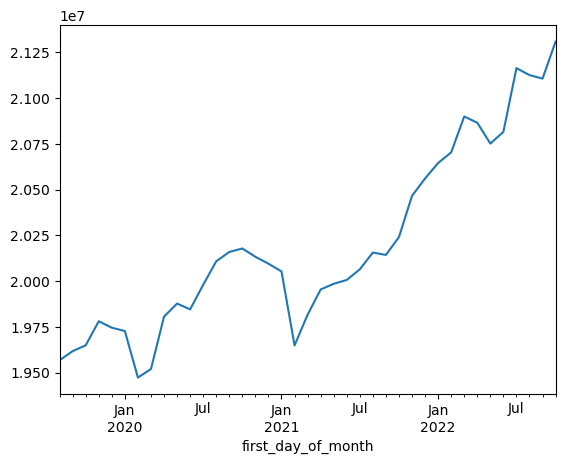

In [673]:
t0.groupby('first_day_of_month')['active'].sum().plot()

# Analyze

## Adjust target by population

In [188]:
t2 = pd.merge(df_train, df_population, 'left', 'row_id')

In [192]:
t2.groupby(['cfips', 'year'])['population_x1000'].std().value_counts()

0.0    12540
Name: population_x1000, dtype: int64

### Per state target data

In [ ]:
train_dates, eval_dates = split_dates(df_train)

In [ ]:
ma

In [ ]:
train_data = df_train[df_train["first_day_of_month"].isin(train_dates)]
eval_data = df_train[df_train["first_day_of_month"].isin(eval_dates)]

In [690]:
manage_data_split = ManageDataSplit(df_train)
train_data = manage_data_split.get_train_data()

In [720]:
# def add_feature_targets_groupby_stats(
#     df,
#     col_group,
#     new_col_template="{}_target_{}",
#     agg_functions=["mean", "std", "median"],
# ):
#     t0 = df.groupby(col_group)["microbusiness_density"].agg(agg_functions)
#     t0.columns = [new_col_template.format(col_group, x) for x in t0.columns]

#     df = pd.merge(df, t0, "left", left_on=col_group, right_index=True)

#     return df

In [834]:
def add_feature_targets_groupby_stats(
    df,
    f_col,
    # new_col_template="{}_target_{}",
    agg_function=None,
    # agg_functions=["mean", "std", "median"],
    train_idx=None,
    col=None,
    **kwargs
):
    df = df.copy()
    t0 = df.groupby(col)["microbusiness_density"].agg(agg_function)
    t0 = t0.rename(f_col)

    df = pd.merge(df, t0, "left", left_on=col, right_index=True).set_index('row_id')
    return pd.DataFrame(df[f_col])

In [835]:
add_feature_targets_groupby_stats(df_train, 'ttttt', agg_function='mean', col='state')

,ttttt
row_id,
1001_2019-08-01,2.223274
1001_2019-09-01,2.223274
1001_2019-10-01,2.223274
1001_2019-11-01,2.223274
1001_2019-12-01,2.223274
...,...
56045_2022-06-01,9.036705
56045_2022-07-01,9.036705
56045_2022-08-01,9.036705


In [695]:
add_feature_targets_groupby_stats(train_data, "state")

,cfips,county,state,first_day_of_month,microbusiness_density,active,state_target_mean,state_target_std,state_target_median
row_id,,,,,,,,,
1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2.172238,1.594450,1.572362
1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2.172238,1.594450,1.572362
1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2.172238,1.594450,1.572362
1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2.172238,1.594450,1.572362
1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2.172238,1.594450,1.572362
...,...,...,...,...,...,...,...,...,...
56045_2021-02-01,56045,Weston County,Wyoming,2021-02-01,1.724448,96,7.968912,11.351673,3.663986
56045_2021-03-01,56045,Weston County,Wyoming,2021-03-01,1.760374,98,7.968912,11.351673,3.663986
56045_2021-04-01,56045,Weston County,Wyoming,2021-04-01,1.724448,96,7.968912,11.351673,3.663986
